## 5. Features Selection

### 5.1 Import Library and loading Dataset

In [2]:
# =============================================================================
#  CORE LIBRARIES
# =============================================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# =============================================================================
#  SCIKIT-LEARN: Preprocessing, Feature Selection, Pipeline, CV, Metrics
# =============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----------------------------------------------------------------------
#  Models: Base Regressors
# ----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# =============================================================================
#  BOOSTING LIBRARIES
# =============================================================================
import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

import catboost as cb
from catboost import CatBoostRegressor

# =============================================================================
#  HYPERPARAMETER OPTIMIZATION & UTILS
# =============================================================================
from scipy.stats import uniform, randint
import optuna
import joblib

In [5]:
#Loading processed data
df = pd.read_csv('../data/processed/feature_engineering_daily_data2.csv', index_col='datetime')
print(df.shape)

(3619, 790)


### 5.2 Building Preprocessing pipeline and Features Selection

In [6]:
X = df.drop(columns=['target5+', 'target4+', 'target3+', 'target2+', 'target1+'])
y = df[['target5+', 'target4+', 'target3+', 'target2+', 'target1+']]

In [7]:
def build_preprocessing_pipeline(X):
    """Xây dựng ColumnTransformer cho tiền xử lý số và phân loại."""
    
    # Phân loại cột
    cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    # Các cột số (loại trừ các cột nhị phân/integer mà ta muốn giữ nguyên nếu có)
    num_cols = X.select_dtypes(include=[np.number], exclude=['bool']).columns.tolist()

    print(f"Numerical Features ({len(num_cols)}): {num_cols}")
    print(f"Categorical Features ({len(cat_cols)}): {cat_cols}")
    print("-" * 40)

    # Sub-pipeline cho các biến số (Impute bằng trung vị, sau đó Scale)
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Sub-pipeline cho các biến phân loại (Impute bằng hằng số, sau đó One-Hot Encode)
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # ColumnTransformer kết hợp hai sub-pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, num_cols),
            ('cat', categorical_pipeline, cat_cols)
        ],
        remainder='passthrough', # Giữ lại các cột không được xử lý nếu có
        verbose_feature_names_out=False
    )
    
    return preprocessor

def run_feature_selection_rf_cv(X, y, k_features=100, test_size=0.2, random_state=42):
    """
    Feature Selection dựa trên RandomForest + Permutation Importance
    HỖ TRỢ MULTI-OUTPUT (nhiều biến y)
    """
    # Chuẩn hóa y thành 2D: (n_samples, n_targets)
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y_values = y.values if isinstance(y, pd.DataFrame) else y.values.reshape(-1, 1)
    else:
        y_values = y.reshape(-1, 1) if y.ndim == 1 else y

    n_targets = y_values.shape[1]
    target_names = y.columns.tolist() if isinstance(y, pd.DataFrame) else [f"target_{i}" for i in range(n_targets)]

    print(f"Detected {n_targets} target(s): {target_names}")
    print(f"Using simple train/test split ({1-test_size:.0%}/{test_size:.0%})")
    print("="*80)

    # Chia dữ liệu
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_values[:split_idx], y_values[split_idx:]

    # Preprocessing
    preprocessor = build_preprocessing_pipeline(X)
    X_train_p = preprocessor.fit_transform(X_train)
    X_test_p = preprocessor.transform(X_test)
    feature_names = preprocessor.get_feature_names_out()

    # Mô hình: MultiOutput nếu cần
    base_rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=random_state,
        n_jobs=-1
    )
    rf = MultiOutputRegressor(base_rf) if n_targets > 1 else base_rf

    print("Fitting RandomForest on training set...", end=" ")
    rf.fit(X_train_p, y_train)
    print("Done.")

    # Dự đoán & tính R² cho từng target
    y_pred = rf.predict(X_test_p)
    r2_per_target = []
    for t in range(n_targets):
        r2 = r2_score(y_test[:, t], y_pred[:, t])
        r2_per_target.append(r2)
    mean_r2 = np.mean(r2_per_target)

    print(f"Mean R² on test set: {mean_r2:.4f}")
    print(f"Per-target R²: {dict(zip(target_names, np.round(r2_per_target, 4)))}")
    print("-"*80)

    # Permutation Importance cho từng target
    print("Computing Permutation Importance for each target...")
    perm_importances_per_target = []

    for t in range(n_targets):
        print(f"  Target {t+1}/{n_targets}: {target_names[t]}...", end=" ")
        estimator_t = rf.estimators_[t] if n_targets > 1 else rf
        y_test_t = y_test[:, t]

        perm = permutation_importance(
            estimator_t,
            X_test_p,
            y_test_t,
            n_repeats=10,
            random_state=random_state,
            n_jobs=-1,
            scoring='r2'
        )
        perm_importances_per_target.append(perm.importances_mean)
        print(f"Done.")
    
    perm_importances_per_target = np.array(perm_importances_per_target)  # (n_targets, n_features)

    # Tổng hợp: trung bình importance qua các target
    mean_importance = perm_importances_per_target.mean(axis=0)  # (n_features,)
    std_importance = perm_importances_per_target.std(axis=0)

    print("="*80)
    print(f"TOP {k_features} FEATURES (Averaged Permutation Importance across {n_targets} targets)")
    print("="*80)

    # Sắp xếp và chọn top k
    sorted_idx = mean_importance.argsort()[::-1]
    top_k_idx = sorted_idx[:k_features]
    top_k_features = [feature_names[i] for i in top_k_idx]

    # Hiển thị top 20
    for i, idx in enumerate(top_k_idx[:20], 1):
        name = feature_names[idx]
        imp = mean_importance[idx]
        std = std_importance[idx]
        print(f"  {i:2d}. {name:<50} {imp:+.6f} (±{std:.4f})")

    print(f"\nSelected {len(top_k_features)} features for final model.")
    print("="*80)

    return {
        'top_features': top_k_features,
        'importance_mean': mean_importance,
        'importance_per_target': perm_importances_per_target,
        'importance_std': std_importance,
        'feature_names': feature_names,
        'r2_per_target': r2_per_target,
        'r2_mean': mean_r2,
        'X_test': X_test_p,
        'y_test': y_test,
        'y_pred': y_pred
    }, preprocessor

In [8]:
selection_result, preprocessor = run_feature_selection_rf_cv(
    X, y, k_features=100, test_size=0.2, random_state=42
)

# Lấy top features
top_features = selection_result['top_features']

# Dùng để transform dữ liệu cuối cùng
X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)[top_features]

Detected 5 target(s): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Using simple train/test split (80%/20%)
Numerical Features (783): ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'year', 'temp_range', 'day_length_hours', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'temp_solar_interaction', 'uv_temp_interaction', 'temp_cloudcover_interaction', 'temp_sealevelpressure_interaction', 'weighted_precip', 'effective_solar', 'precip_impact', 'wind_u', 'wind_v', 'moonphase_sin', 'moonphase_cos', 'tempmax_lag_1', 'tempmax_lag_2', 'tempmax_lag_3', 'tempmax_lag_5', 'tempmax_lag_7', 'tempmax_lag_10', 'tempmax_lag_14', 'tempmax_lag_21', 'tempmax_lag_30', 'tempmin_lag_1', 'tempmin_lag_2', 'tempmin_lag_3', 'tempmin_lag_5', 'tempmin_lag_7', 'tempmin_lag_10', 'tempmin_lag

In [13]:
import joblib
# LƯU
joblib.dump(selection_result, 'selection_result.joblib')

['selection_result.joblib']

In [ ]:
# ĐỌC
selection_result = joblib.load('selection_result.joblib')

### 5.3 Selecting top K feature (After testing, k=93 return the best R2)

In [14]:
mean_importance = selection_result['importance_mean']
feature_names = selection_result['feature_names']
k_features = 93

sorted_idx = mean_importance.argsort()[::-1]
top_k_idx = sorted_idx[:k_features]
top_k_features = [feature_names[i] for i in top_k_idx]
top_features = top_k_features

X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)[top_features]

# Print top k features
print("Top selected features:")
print(X_selected.columns)

Top selected features:
Index(['day_length_hours_lag_21', 'day_length_hours_lag_30',
       'temp_sealevelpressure_interaction', 'feelslike', 'temp',
       'day_avg_feelslike', 'day_avg_tempmin', 'rolling_30_sealevelpressure',
       'rolling_3_sealevelpressure_change', 'season_avg_sealevelpressure',
       'rolling_3_wind_u_change', 'season_avg_feelslike',
       'rolling_21_cloudcover', 'feelslikemax', 'rolling_7_sealevelpressure',
       'dew', 'rolling_3_sealevelpressure', 'tempmax', 'wind_u',
       'sealevelpressure_lag_1', 'season_avg_effective_solar',
       'rolling_7_sealevelpressure_change',
       'rolling_14_temp_solar_interaction', 'rolling_14_tempmin_change',
       'temp_anomaly_vs_month_avg', 'tempmin', 'month_avg_tempmin',
       'season_avg_solarenergy', 'rolling_30_precipcover', 'feelslikemin',
       'season_avg_solarradiation', 'rolling_14_dew_change', 'dew_lag_10',
       'temp_anomaly_vs_season_avg', 'season_avg_day_length_hours',
       'rolling_14_windspeed_ch

### 5.4 Benchmark models with top K features

In [186]:
def benchmark_models_with_top_features(
    X, y, top_features, val_ratio=0.25, test_ratio=0.2, random_state=None, plot=True, base_models=None
):
    """
    Đánh giá nhiều mô hình trên top features.
    - HỖ TRỢ MULTI-OUTPUT (y có nhiều cột)
    - CHIA DỮ LIỆU CỐ ĐỊNH: 60% train / 20% val / 20% test
    - TỰ ĐỘNG XỬ LÝ ĐỊNH DẠNG y CHO TỪNG MODEL
    """
    # === 1. Lấy dữ liệu đã chọn ===
    X_selected = X[top_features].copy()
    
    # Chuẩn hóa y thành DataFrame
    if isinstance(y, (pd.Series, np.ndarray)):
        y = pd.DataFrame(y)
    elif isinstance(y, pd.DataFrame):
        y = y.copy()
    else:
        raise ValueError("y must be DataFrame, Series, or numpy array")
    
    # Đặt tên cột nếu chưa có
    if y.shape[1] == 1:
        y.columns = ['target']
    else:
        y.columns = [f"target_{i}" if col.startswith('Unnamed') or col != f"target_{i}" else col 
                     for i, col in enumerate(y.columns)]
    
    n_samples = len(X_selected)
    n_outputs = y.shape[1]
    target_names = y.columns.tolist()

    # === 2. Chia dữ liệu cố định ===
    test_idx = int(n_samples * (1 - test_ratio))
    train_val_idx = int(test_idx * (1 - val_ratio / (1 - test_ratio)))
    
    X_train = X_selected.iloc[:train_val_idx].copy()
    X_val = X_selected.iloc[train_val_idx:test_idx].copy()
    X_test = X_selected.iloc[test_idx:].copy()
    
    y_train = y.iloc[:train_val_idx].copy()
    y_val = y.iloc[train_val_idx:test_idx].copy()
    y_test = y.iloc[test_idx:].copy()
    
    X_train_val = X_selected.iloc[:test_idx].copy()
    y_train_val = y.iloc[:test_idx].copy()

    print(f"Data split (fixed order):")
    print(f" Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
    print(f" Targets ({n_outputs}): {target_names}")
    print(f" Features: {len(top_features)}")
    print("="*80)

    # === 3. Hàm fit/predict an toàn ===
    def safe_fit_predict(model, X_tr, y_tr, X_v, is_native_multioutput=False):
        if n_outputs == 1:
            model.fit(X_tr, y_tr.iloc[:, 0])
            pred = model.predict(X_v)
            return pred.reshape(-1, 1)  # Luôn trả về 2D
        else:
            if is_native_multioutput:
                model.fit(X_tr, y_tr.values)
                return model.predict(X_v)  # Đã là 2D
            else:
                multi_model = MultiOutputRegressor(model)
                multi_model.fit(X_tr, y_tr)
                return multi_model.predict(X_v)

    # === 5. Huấn luyện & đánh giá ===
    results = {}
    for name, (base_model, native_multi) in base_models.items():
        print(f"Training {name}...", end=" ")
        try:
            y_pred_val = safe_fit_predict(base_model, X_train, y_train, X_val, native_multi)
            # Đảm bảo y_pred_val là 2D
            if y_pred_val.ndim == 1:
                y_pred_val = y_pred_val.reshape(-1, 1)
            
            r2_list = [r2_score(y_val.iloc[:, i], y_pred_val[:, i]) for i in range(n_outputs)]
            r2_mean = np.mean(r2_list)
            mae = mean_absolute_error(y_val, y_pred_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
            
            results[name] = {
                'R2_mean': r2_mean,
                'R2_per_target': r2_list,
                'MAE': mae,
                'RMSE': rmse,
                'base_model': base_model,
                'native_multi': native_multi
            }
            print(f"R²: {r2_mean:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
        except Exception as e:
            print(f"FAILED: {e}")
            results[name] = {'R2_mean': -np.inf, 'MAE': np.inf, 'RMSE': np.inf}

    # === 6. Bảng xếp hạng ===
    df_results = pd.DataFrame({
        'Model': [k for k in results.keys() if results[k]['R2_mean'] != -np.inf],
        'R2_mean': [r['R2_mean'] for r in results.values() if r['R2_mean'] != -np.inf],
        'MAE': [r['MAE'] for r in results.values() if r['MAE'] != np.inf],
        'RMSE': [r['RMSE'] for r in results.values() if r['RMSE'] != np.inf]
    }).round(4).sort_values('R2_mean', ascending=False).reset_index(drop=True)

    print("\n" + "="*80)
    print("RANKING ON VALIDATION SET")
    print("="*80)
    print(df_results.to_string(index=True))

    # === 7. Best model + retrain ===
    if len(df_results) == 0:
        raise ValueError("All models failed!")
        
    best_name = df_results.iloc[0]['Model']
    best_base_model = results[best_name]['base_model']
    native_multi = results[best_name]['native_multi']
    
    print(f"\nBEST MODEL: {best_name} → Retraining on train+val...")
    y_pred_test = safe_fit_predict(best_base_model, X_train_val, y_train_val, X_test, native_multi)
    if y_pred_test.ndim == 1:
        y_pred_test = y_pred_test.reshape(-1, 1)

    # === 8. Test metrics ===
    test_r2_list = [r2_score(y_test.iloc[:, i], y_pred_test[:, i]) for i in range(n_outputs)]
    test_mae_list = [mean_absolute_error(y_test.iloc[:, i], y_pred_test[:, i]) for i in range(n_outputs)]
    test_rmse_list = [np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred_test[:, i])) for i in range(n_outputs)]
    
    test_r2 = np.mean(test_r2_list)
    test_mae = np.mean(test_mae_list)
    test_rmse = np.mean(test_rmse_list)

    print(f"HOLD-OUT TEST → Mean R²: {test_r2:.4f} | Mean MAE: {test_mae:.4f} | Mean RMSE: {test_rmse:.4f}")
    print("\nPer-target performance on TEST set:")
    per_target_df = pd.DataFrame({
        'Target': target_names,
        'R2': [f"{r:.4f}" for r in test_r2_list],
        'MAE': [f"{m:.4f}" for m in test_mae_list],
        'RMSE': [f"{rm:.4f}" for rm in test_rmse_list]
    })
    print(per_target_df.to_string(index=False))

    # === 9. Vẽ biểu đồ ===
    if plot and len(df_results) > 0:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_results, x='R2_mean', y='Model', palette='viridis')
        plt.title('Model Performance (Mean R²)')
        plt.xlabel('R² Score')
        plt.ylabel('Model')
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

    # === 10. Tạo best_model đã train đầy đủ ===
    if n_outputs == 1:
        best_model = best_base_model
        best_model.fit(X_train_val, y_train_val.iloc[:, 0])
    else:
        if native_multi:
            best_model = best_base_model
            best_model.fit(X_train_val, y_train_val.values)
        else:
            best_model = MultiOutputRegressor(best_base_model)
            best_model.fit(X_train_val, y_train_val)

    # === 11. Trả về ===
    return {
        'results_df': df_results,
        'best_model_name': best_name,
        'best_model': best_model,
        'test_metrics': {
            'R2_mean': test_r2,
            'R2_per_target': test_r2_list,
            'MAE': test_mae,
            'RMSE': test_rmse
        },
        'target_names': target_names,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred_test': y_pred_test
    }

Data split (fixed order):
 Train: 1990 | Val: 905 | Test: 724
 Targets (5): ['target_0', 'target_1', 'target_2', 'target_3', 'target_4']
 Features: 90
Training Linear... R²: 0.8254 | MAE: 1.6528 | RMSE: 2.1370
Training Ridge... R²: 0.8276 | MAE: 1.6415 | RMSE: 2.1236
Training Lasso... R²: 0.8259 | MAE: 1.6445 | RMSE: 2.1341
Training Random Forest... R²: 0.8160 | MAE: 1.6878 | RMSE: 2.1937
Training XGBoost... R²: 0.8147 | MAE: 1.6862 | RMSE: 2.2016
Training LightGBM... R²: 0.8128 | MAE: 1.6962 | RMSE: 2.2125
Training CatBoost... R²: 0.8195 | MAE: 1.6621 | RMSE: 2.1725
Training Decision Tree... R²: 0.6309 | MAE: 2.3565 | RMSE: 3.1070
Training KNN... R²: 0.7791 | MAE: 1.8532 | RMSE: 2.4037
Training SVR... R²: 0.7904 | MAE: 1.7796 | RMSE: 2.3415

RANKING ON VALIDATION SET
           Model  R2_mean     MAE    RMSE
0          Ridge   0.8276  1.6415  2.1236
1          Lasso   0.8259  1.6445  2.1341
2         Linear   0.8254  1.6528  2.1370
3       CatBoost   0.8195  1.6621  2.1725
4  Random F

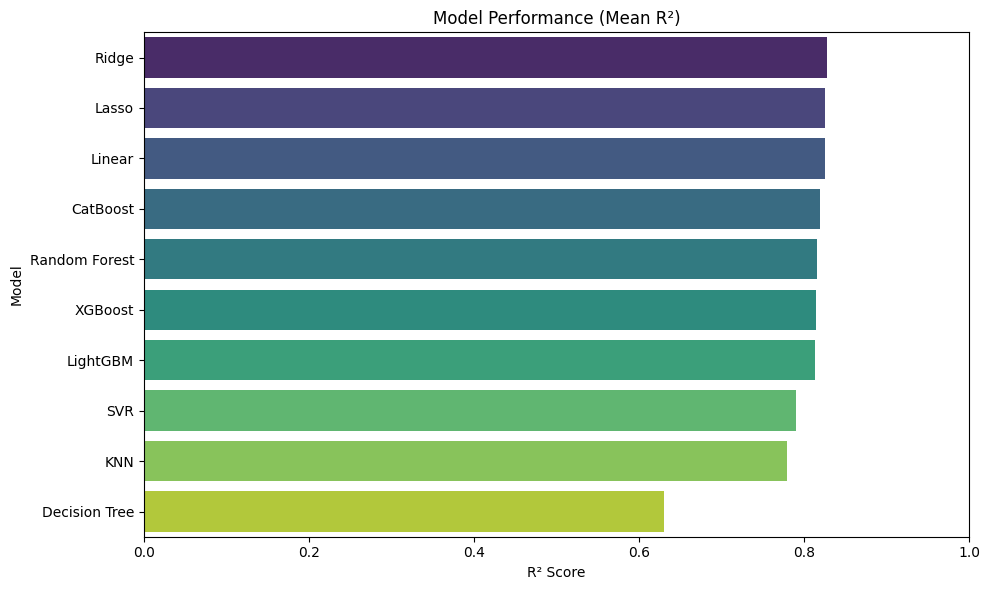

{'results_df':            Model  R2_mean     MAE    RMSE
 0          Ridge   0.8276  1.6415  2.1236
 1          Lasso   0.8259  1.6445  2.1341
 2         Linear   0.8254  1.6528  2.1370
 3       CatBoost   0.8195  1.6621  2.1725
 4  Random Forest   0.8160  1.6878  2.1937
 5        XGBoost   0.8147  1.6862  2.2016
 6       LightGBM   0.8128  1.6962  2.2125
 7            SVR   0.7904  1.7796  2.3415
 8            KNN   0.7791  1.8532  2.4037
 9  Decision Tree   0.6309  2.3565  3.1070,
 'best_model_name': 'Ridge',
 'best_model': MultiOutputRegressor(estimator=Ridge()),
 'test_metrics': {'R2_mean': np.float64(0.8112887591853951),
  'R2_per_target': [0.7523314167771104,
   0.763051237429626,
   0.787951617082955,
   0.8345228164035678,
   0.9185867082337162],
  'MAE': np.float64(1.6843071416822233),
  'RMSE': np.float64(2.1727752826654996)},
 'target_names': ['target_0', 'target_1', 'target_2', 'target_3', 'target_4'],
 'X_test':       day_length_hours_lag_21  day_length_hours_lag_30  \
 28

In [189]:
# === 4. Danh sách mô hình ===
base_models = {
    'Linear': (LinearRegression(), False),
    'Ridge': (Ridge(alpha=1.0), False),
    'Lasso': (Lasso(alpha=0.1, max_iter=10000), False),
    'Random Forest': (RandomForestRegressor(
        n_estimators=300, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=42, n_jobs=-1
    ), True),
    'XGBoost': (xgb.XGBRegressor(
        n_estimators=300, max_depth=8, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, verbosity=0
    ), True),
    'LightGBM': (lgb.LGBMRegressor(
        n_estimators=300, max_depth=8, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1
    ), False),  # LightGBM KHÔNG hỗ trợ multi-output → dùng MultiOutputRegressor
    'CatBoost': (cb.CatBoostRegressor(
        n_estimators=300, 
        depth=8, 
        learning_rate=0.1,
        loss_function='MultiRMSE',   # ← THÊM DÒNG NÀY
        random_state=42, 
        verbose=False
    ), True),
    'Decision Tree': (DecisionTreeRegressor(max_depth=15, min_samples_split=5, random_state=42), False),
    'KNN': (KNeighborsRegressor(n_neighbors=5, weights='distance'), False),
    'SVR': (SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.1), False)
}

benchmark_models_with_top_features(X_selected, y, top_features, base_models=base_models)

## Linear Model

In [15]:
def linear_regression(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    plot=True
):
    """
    Chỉ chạy Linear Regression (hỗ trợ multi-output)
    Chia 80% train / 20% test
    In chi tiết R², MAE, RMSE cho từng target + trung bình
    """
    # === 1. Chuẩn hóa y ===
    if isinstance(y, (pd.Series, np.ndarray)):
        y_df = pd.DataFrame(y)
    else:
        y_df = y.copy()
    
    if y_df.shape[1] == 1:
        y_df.columns = ['target']
    else:
        y_df.columns = [col if not col.startswith('Unnamed') else f'target_{i}' 
                       for i, col in enumerate(y_df.columns)]
    
    target_names = y_df.columns.tolist()
    n_targets = len(target_names)
    
    print(f"Linear Regression | {n_targets} target(s): {target_names}")
    print(f"Data: {X.shape[0]:,} samples × {X.shape[1]:,} features")
    print("="*80)

    # === 2. Chia train/test ===
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

    # === 3. Tạo model ===
    if n_targets == 1:
        model = LinearRegression()
        model.fit(X_train, y_train.iloc[:, 0])
        y_pred = model.predict(X_test).reshape(-1, 1)
    else:
        model = MultiOutputRegressor(LinearRegression())
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # === 4. Tính metrics ===
    r2_list = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    mae_list = [mean_absolute_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    rmse_list = [np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i])) for i in range(n_targets)]
    
    r2_mean = np.mean(r2_list)
    mae_mean = np.mean(mae_list)
    rmse_mean = np.mean(rmse_list)

    # === 5. In kết quả đẹp ===
    print(f"\nLINEAR REGRESSION RESULTS (Test set - {test_size:.0%})")
    print("-" * 80)
    print(f"{'Target':<15} {'R²':>8} {'MAE':>10} {'RMSE':>10}")
    print("-" * 80)
    for name, r2, mae, rmse in zip(target_names, r2_list, mae_list, rmse_list):
        print(f"{name:<15} {r2:8.4f} {mae:10.4f} {rmse:10.4f}")
    print("-" * 80)
    print(f"{'MEAN':<15} {r2_mean:8.4f} {mae_mean:10.4f} {rmse_mean:10.4f}")
    print("=" * 80)

    # === 6. Vẽ biểu đồ (nếu muốn) ===
    if plot and n_targets <= 5:
        plt.figure(figsize=(10, 6))
        for i in range(n_targets):
            plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.6, label=target_names[i])
        plt.plot([y_test.min().min(), y_test.max().max()], 
                 [y_test.min().min(), y_test.max().max()], 'r--', lw=2)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title(f'Linear Regression - True vs Predicted (R² mean = {r2_mean:.4f})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # === 7. Trả về ===
    return {
        'model': model,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'metrics': {
            'R2_per_target': dict(zip(target_names, r2_list)),
            'MAE_per_target': dict(zip(target_names, mae_list)),
            'RMSE_per_target': dict(zip(target_names, rmse_list)),
            'R2_mean': r2_mean,
            'MAE_mean': mae_mean,
            'RMSE_mean': rmse_mean
        },
        'target_names': target_names
    }

Linear Regression | 5 target(s): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Data: 3,619 samples × 46 features
Train: 2,895 | Test: 724

LINEAR REGRESSION RESULTS (Test set - 20%)
--------------------------------------------------------------------------------
Target                R²        MAE       RMSE
--------------------------------------------------------------------------------
target5+          0.7633     1.9669     2.4721
target4+          0.7736     1.9206     2.4179
target3+          0.7937     1.8206     2.3082
target2+          0.8351     1.6307     2.0651
target1+          0.9170     1.1415     1.4668
--------------------------------------------------------------------------------
MEAN              0.8165     1.6960     2.1460


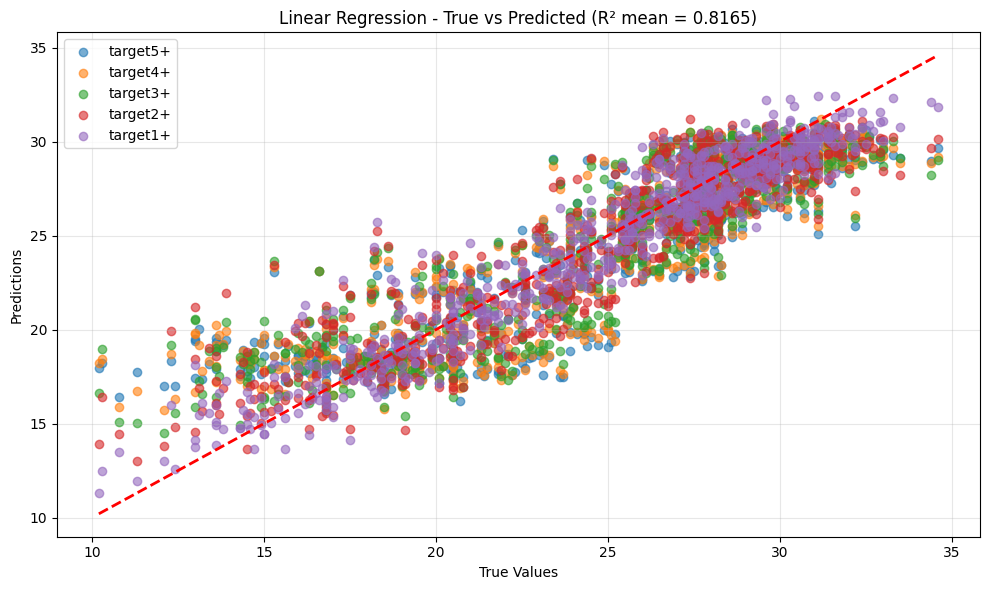

In [201]:
result = linear_regression(X_selected, y, plot=True)

In [16]:
def random_forest(
    X, y,
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    test_size=0.2,
    random_state=42,
    plot=True,
    verbose=True
):
    """
    Chỉ chạy Random Forest Regressor (hỗ trợ multi-output)
    80% train / 20% test
    In chi tiết + vẽ biểu đồ đẹp
    """
    # === 1. Chuẩn hóa y ===
    if isinstance(y, (pd.Series, np.ndarray)):
        y_df = pd.DataFrame(y)
    else:
        y_df = y.copy()
    
    if y_df.shape[1] == 1:
        y_df.columns = ['target']
    else:
        y_df.columns = [f"target_{i}" if col.startswith('Unnamed') else col 
                       for i, col in enumerate(y_df.columns)]
    
    target_names = y_df.columns.tolist()
    n_targets = len(target_names)
    
    if verbose:
        print(f"RANDOM FOREST REGRESSOR")
        print(f"Targets ({n_targets}): {target_names}")
        print(f"Data: {X.shape[0]:,} samples × {X.shape[1]:,} features")
        print(f"Model: n_estimators={n_estimators}, max_depth={max_depth or 'None'}")
        print("="*90)

    # === 2. Chia train/test ===
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    if verbose:
        print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

    # === 3. Train Random Forest (native multi-output) ===
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state,
        n_jobs=-1,
        warm_start=False
    )
    
    if n_targets == 1:
        rf.fit(X_train, y_train.iloc[:, 0])
        y_pred = rf.predict(X_test).reshape(-1, 1)
    else:
        rf.fit(X_train, y_train.values)  # RandomForest hỗ trợ native multi-output
        y_pred = rf.predict(X_test)

    # === 4. Tính metrics ===
    r2_list = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    mae_list = [mean_absolute_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    rmse_list = [np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i])) for i in range(n_targets)]
    
    r2_mean = np.mean(r2_list)
    mae_mean = np.mean(mae_list)
    rmse_mean = np.mean(rmse_list)

    # === 5. In kết quả đẹp ===
    if verbose:
        print(f"\nRANDOM FOREST RESULTS (Test set - {test_size:.0%})")
        print("-" * 90)
        print(f"{'Target':<18} {'R²':>10} {'MAE':>12} {'RMSE':>12}")
        print("-" * 90)
        for name, r2, mae, rmse in zip(target_names, r2_list, mae_list, rmse_list):
            print(f"{name:<18} {r2:10.4f} {mae:12.4f} {rmse:12.4f}")
        print("-" * 90)
        print(f"{'MEAN':<18} {r2_mean:10.4f} {mae_mean:12.4f} {rmse_mean:12.4f}")
        print("="*90)

    # === 6. Vẽ biểu đồ đẹp ===
    if plot:
        plt.figure(figsize=(12, 5))
        
        # Subplot 1: True vs Predicted
        plt.subplot(1, 2, 1)
        colors = sns.color_palette("husl", n_targets)
        for i in range(n_targets):
            plt.scatter(y_test.iloc[:, i], y_pred[:, i], 
                       alpha=0.6, label=target_names[i], color=colors[i], s=50)
        mins = min(y_test.min().min(), y_pred.min().min())
        maxs = max(y_test.max().max(), y_pred.max().max())
        plt.plot([mins, maxs], [mins, maxs], 'r--', lw=2, label='Perfect')
        plt.xlabel('True Values', fontsize=12)
        plt.ylabel('Predictions', fontsize=12)
        plt.title(f'Random Forest\nMean R² = {r2_mean:.4f}', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Subplot 2: Residuals
        plt.subplot(1, 2, 2)
        residuals = y_test.values - y_pred
        for i in range(n_targets):
            sns.kdeplot(residuals[:, i], label=target_names[i], fill=True, alpha=0.5)
        plt.xlabel('Residuals')
        plt.ylabel('Density')
        plt.title('Residual Distribution')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # === 7. Feature Importance (top 15) ===
    if hasattr(rf, 'feature_importances_'):
        importances = rf.feature_importances_
        if n_targets > 1:
            # Trung bình importance qua các cây của tất cả target
            imp_per_tree = np.array([est.feature_importances_ for est in rf.estimators_])
            importances = imp_per_tree.mean(axis=0)
        
        top_idx = np.argsort(importances)[::-1][:15]
        top_features = X.columns[top_idx]
        top_values = importances[top_idx]

        if verbose:
            print(f"\nTOP 15 FEATURES (Gini Importance)")
            print("-" * 50)
            for i, (feat, val) in enumerate(zip(top_features, top_values), 1):
                print(f"{i:2d}. {feat:<30} {val:.5f}")
            print()

        # Vẽ feature importance
        if plot:
            plt.figure(figsize=(10, 6))
            sns.barplot(x=top_values, y=top_features, palette="viridis")
            plt.title("Top 15 Feature Importances (Random Forest)")
            plt.xlabel("Importance")
            plt.tight_layout()
            plt.show()

    # === 8. Trả về ===
    return {
        'model': rf,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': pd.DataFrame(y_pred, columns=target_names, index=y_test.index),
        'metrics': {
            'R2_per_target': dict(zip(target_names, r2_list)),
            'MAE_per_target': dict(zip(target_names, mae_list)),
            'RMSE_per_target': dict(zip(target_names, rmse_list)),
            'R2_mean': r2_mean,
            'MAE_mean': mae_mean,
            'RMSE_mean': rmse_mean
        },
        'feature_importance': pd.Series(importances, index=X.columns).sort_values(ascending=False),
        'target_names': target_names
    }

RANDOM FOREST REGRESSOR
Targets (5): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Data: 3,619 samples × 93 features
Model: n_estimators=500, max_depth=None
Train: 2,895 | Test: 724

RANDOM FOREST RESULTS (Test set - 20%)
------------------------------------------------------------------------------------------
Target                     R²          MAE         RMSE
------------------------------------------------------------------------------------------
target5+               0.7551       2.0191       2.5144
target4+               0.7654       1.9824       2.4612
target3+               0.7868       1.8832       2.3469
target2+               0.8282       1.6606       2.1084
target1+               0.9017       1.2537       1.5957
------------------------------------------------------------------------------------------
MEAN                   0.8074       1.7598       2.2053


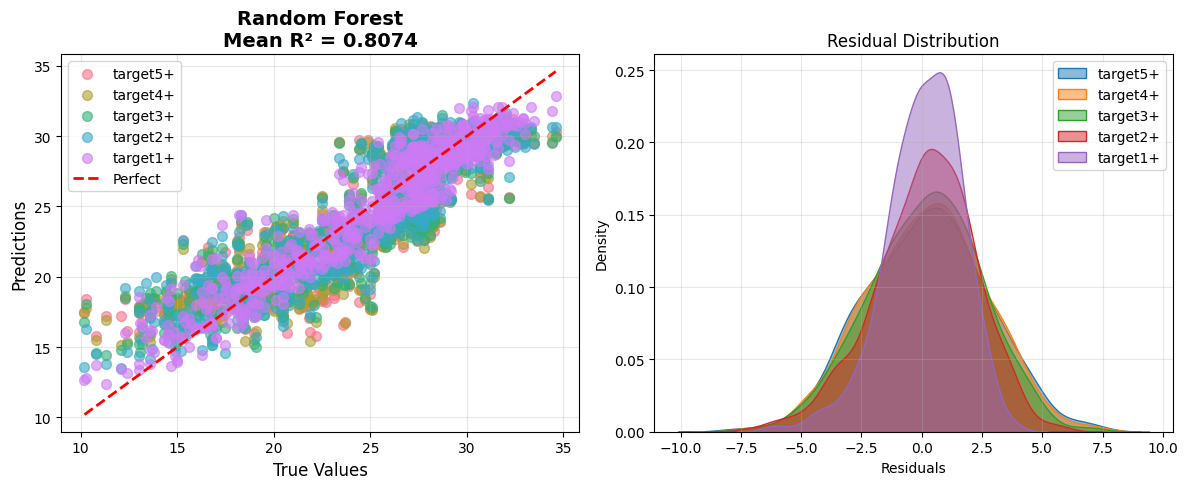


TOP 15 FEATURES (Gini Importance)
--------------------------------------------------
 1. day_length_hours_lag_21        0.45851
 2. day_length_hours_lag_30        0.26563
 3. temp_sealevelpressure_interaction 0.02506
 4. season_avg_day_length_hours    0.01590
 5. day_avg_feelslike              0.01545
 6. month_avg_tempmin              0.01322
 7. season_avg_sealevelpressure    0.01101
 8. temp_anomaly_vs_season_avg     0.00573
 9. tempmax                        0.00545
10. feelslike                      0.00538
11. feelslikemax                   0.00511
12. temp                           0.00511
13. month_avg_feelslikemin         0.00494
14. rolling_30_temp_solar_interaction 0.00490
15. wind_u                         0.00401



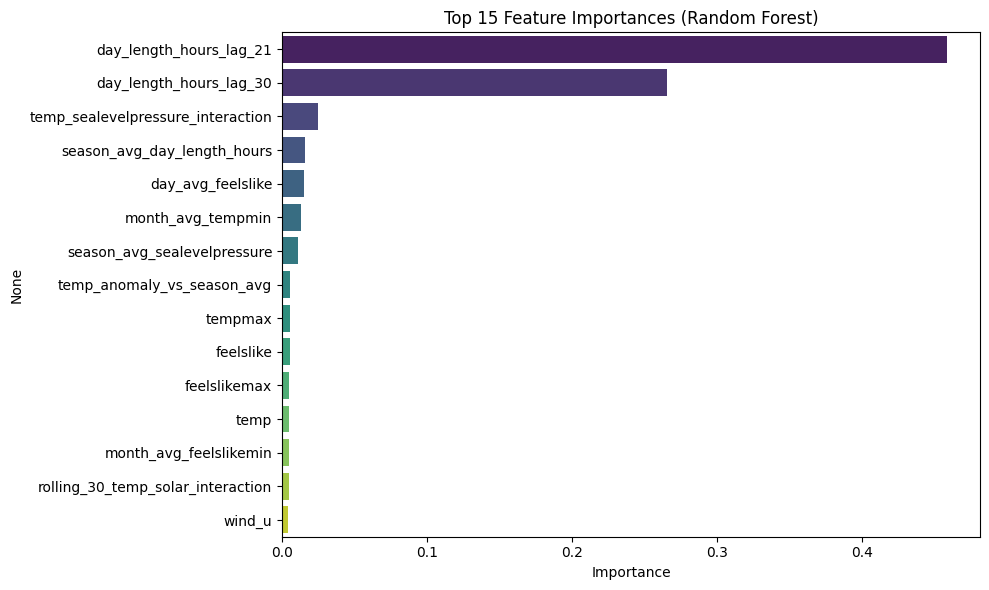

In [17]:
result = random_forest(X_selected, y, n_estimators=500, plot=True)

### 5.6 Finding the best top K features

Time-series split: Train 2,895 | Test 724
Targets (5): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Total features available: 789

Evaluating top 5 features...
  → Linear       R² = 0.80514
  → Ridge        R² = 0.80250
  → Lasso        R² = 0.79038
  → Random Forest R² = 0.77855
  → XGBoost      R² = 0.73292
  → CatBoost     R² = 0.78000

Evaluating top 6 features...
  → Linear       R² = 0.80515
  → Ridge        R² = 0.80248
  → Lasso        R² = 0.79038
  → Random Forest R² = 0.78381
  → XGBoost      R² = 0.75072
  → CatBoost     R² = 0.78766

Evaluating top 7 features...
  → Linear       R² = 0.80507
  → Ridge        R² = 0.80243
  → Lasso        R² = 0.79089
  → Random Forest R² = 0.78588
  → XGBoost      R² = 0.75626
  → CatBoost     R² = 0.78860

Evaluating top 8 features...
  → Linear       R² = 0.80576
  → Ridge        R² = 0.80343
  → Lasso        R² = 0.79090
  → Random Forest R² = 0.78569
  → XGBoost      R² = 0.76428
  → CatBoost     R² = 0.79092

Evaluatin

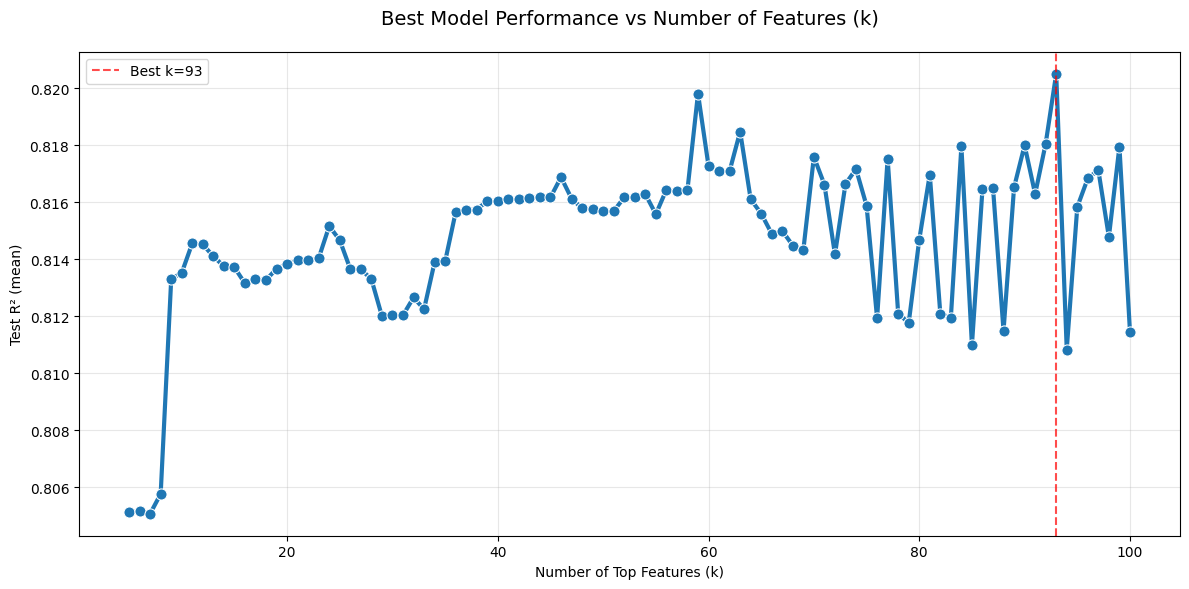

In [ ]:
# ==============================
# 1. Danh sách các model
# ==============================
base_models = {
    'Linear': (LinearRegression(), False),
    'Ridge': (Ridge(alpha=1.0), False),
    'Lasso': (Lasso(alpha=0.1, max_iter=10000), False),
    'Random Forest': (RandomForestRegressor(
        n_estimators=300, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=42, n_jobs=-1
    ), True),
    'XGBoost': (xgb.XGBRegressor(
        n_estimators=300, max_depth=8, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, verbosity=0
    ), True),
    'CatBoost': (cb.CatBoostRegressor(
        iterations=300,
        depth=8,
        learning_rate=0.1,
        loss_function='MultiRMSE',
        random_state=42,
        verbose=False
    ), True),
}

# ==============================
# 2. Hàm đánh giá với k features (ĐÃ FIX HOÀN TOÀN)
# ==============================
def evaluate_k_features(
    X_selected,
    y,
    selection_result,
    k_range=range(5, 101, 5),
    test_size=0.2,
    output_csv="k_features_comparison.csv"
):
    """
    Duyệt qua nhiều k, chọn top k features, train 80/20 (time-series split), lưu CSV
    """
    mean_importance = selection_result['importance_mean']
    feature_names = selection_result['feature_names']
    
    # Sắp xếp feature theo importance
    sorted_idx = mean_importance.argsort()[::-1]
    
    # Chuẩn bị y đúng cách
    if isinstance(y, (pd.Series, np.ndarray)):
        y = pd.DataFrame(y, columns=['target'])
    elif isinstance(y, pd.DataFrame):
        y = y.copy()
    else:
        raise ValueError("y must be DataFrame, Series or array")
    
    if y.shape[1] == 1 and y.columns[0] != 'target':
        y.columns = ['target']
    
    target_names = y.columns.tolist()
    n_targets = len(target_names)
    
    # Chia train/test theo thời gian (không shuffle)
    split_idx = int(len(X_selected) * (1 - test_size))
    X_train = X_selected.iloc[:split_idx].copy()
    X_test = X_selected.iloc[split_idx:].copy()
    y_train = y.iloc[:split_idx].copy()
    y_test = y.iloc[split_idx:].copy()
    
    print(f"Time-series split: Train {len(X_train):,} | Test {len(X_test):,}")
    print(f"Targets ({n_targets}): {target_names}")
    print(f"Total features available: {X_selected.shape[1]:,}")
    print("="*80)
    
    results_list = []
    
    for k in k_range:
        if k > len(feature_names):
            print(f"k={k} > số feature có sẵn ({len(feature_names)}), bỏ qua...")
            continue
            
        print(f"\nEvaluating top {k} features...")
        
        # Lấy top k features
        top_k_idx = sorted_idx[:k]
        top_k_features = [feature_names[i] for i in top_k_idx]
        
        X_train_k = X_train[top_k_features]
        X_test_k = X_test[top_k_features]
        
        # Train & evaluate từng model
        for model_name, (base_model, native_multi) in base_models.items():
            print(f"  → {model_name:<12}", end=" ")
            
            try:
                # Fit
                if n_targets == 1:
                    model_to_fit = base_model
                    model_to_fit.fit(X_train_k, y_train.iloc[:, 0])
                    pred_test = model_to_fit.predict(X_test_k).reshape(-1, 1)
                else:
                    if native_multi:
                        model_to_fit = base_model
                        model_to_fit.fit(X_train_k, y_train.values)
                        pred_test = model_to_fit.predict(X_test_k)
                    else:
                        wrapper = MultiOutputRegressor(base_model)
                        wrapper.fit(X_train_k, y_train.values)
                        pred_test = wrapper.predict(X_test_k)
                
                # Đảm bảo pred_test là 2D
                if pred_test.ndim == 1:
                    pred_test = pred_test.reshape(-1, 1)
                
                # Tính metrics
                r2_list = []
                for i in range(n_targets):
                    r2 = r2_score(y_test.iloc[:, i], pred_test[:, i])
                    r2_list.append(r2)
                
                r2_mean = np.mean(r2_list)
                mae_mean = mean_absolute_error(y_test, pred_test)
                rmse_mean = np.sqrt(mean_squared_error(y_test, pred_test))
                
                print(f"R² = {r2_mean:.5f}")
                
                # Lưu kết quả
                results_list.append({
                    'k': k,
                    'model': model_name,
                    'R2_mean': round(r2_mean, 6),
                    'R2_per_target': ' | '.join([f"{target_names[i]}:{r2_list[i]:.4f}" for i in range(n_targets)]),
                    'MAE_mean': round(mae_mean, 6),
                    'RMSE_mean': round(rmse_mean, 6),
                    'features': ' | '.join(top_k_features),
                    'top_10_features': ', '.join(top_k_features[:10]) + ('...' if len(top_k_features) > 10 else '')
                })
                
            except Exception as e:
                print(f"FAILED → {e}")
                results_list.append({
                    'k': k,
                    'model': model_name,
                    'R2_mean': -999.0,
                    'MAE_mean': 999.0,
                    'RMSE_mean': 999.0,
                    'error': str(e)
                })
    
    # ==============================
    # 3. Lưu và phân tích kết quả
    # ==============================
    results_df = pd.DataFrame(results_list)
    
    # Loại lỗi & tìm best
    valid_df = results_df[results_df['R2_mean'] > -999].copy()
    if len(valid_df) == 0:
        raise ValueError("Tất cả model đều lỗi!")
    
    best_row = valid_df.loc[valid_df['R2_mean'].idxmax()]
    
    print("\n" + "="*80)
    print("BEST CONFIGURATION FOUND")
    print("="*80)
    print(f"k = {best_row['k']}")
    print(f"Model = {best_row['model']}")
    print(f"R² mean = {best_row['R2_mean']:.6f}")
    print(f"MAE = {best_row['MAE_mean']:.6f} | RMSE = {best_row['RMSE_mean']:.6f}")
    print(f"Top 10 features: {best_row['top_10_features']}")
    
    # Lưu CSV
    results_df.to_csv(output_csv, index=False)
    print(f"\nĐã lưu toàn bộ kết quả → {output_csv}")
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    best_per_k = valid_df.loc[valid_df.groupby('k')['R2_mean'].idxmax()]
    sns.lineplot(data=best_per_k, x='k', y='R2_mean', marker='o', linewidth=3, markersize=8)
    plt.title('Best Model Performance vs Number of Features (k)', fontsize=14, pad=20)
    plt.xlabel('Number of Top Features (k)')
    plt.ylabel('Test R² (mean)')
    plt.grid(True, alpha=0.3)
    plt.axvline(best_row['k'], color='red', linestyle='--', alpha=0.7, label=f"Best k={best_row['k']}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return results_df, best_row

X_selected = pd.DataFrame(
    preprocessor.transform(X),
    columns=preprocessor.get_feature_names_out()
)
results_df, best_config = evaluate_k_features(
    X_selected , y=y,
    selection_result=selection_result,
    k_range=range(5, 101, 1),  # thử 10,15,20,...,100
    test_size=0.2,
    output_csv="best_k_features_temp.csv"
)

### 5.7 Reverify the best model

In [28]:
def build_preprocessing_pipeline_catboost(X):
    """
    Pipeline TỐI ƯU CHO CATBOOST:
    - Chỉ impute số (median)
    - KHÔNG scale (CatBoost không cần)
    - Categorical: passthrough nguyên bản → để CatBoost tự xử lý
    """
    # 1. Phân loại cột - CHỐNG LỖI khi có cột bool bị nhầm
    cat_cols = X.select_dtypes(include=['object', 'category', 'string']).columns.tolist()
    bool_cols = X.select_dtypes(include=['bool']).columns.tolist()
    cat_cols.extend(bool_cols)  # bool cũng là categorical với CatBoost
    
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Loại bỏ các cột bool khỏi num_cols nếu chúng bị nhầm
    num_cols = [col for col in num_cols if col not in bool_cols]

    print(f"Numerical Features ({len(num_cols)}): {num_cols}")
    print(f"Categorical Features ({len(cat_cols)}): {cat_cols}")
    print("-" * 50)

    # 2. Pipeline cho số: chỉ impute, KHÔNG scale
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', 'passthrough')  # CatBoost không cần StandardScaler
    ])

    # 3. ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, num_cols),
            ('cat', 'passthrough', cat_cols)  # CatBoost sẽ tự xử lý
        ],
        remainder='drop',  # đổi thành 'drop' cho an toàn
        verbose_feature_names_out=False
    )
    
    # Đặt tên để dễ debug
    preprocessor.set_output(transform="pandas")
    
    return preprocessor

In [34]:
def cat_boost_regression(
    X, y,
    top_features=None,
    iterations=3000,
    depth=8,
    learning_rate=0.05,
    test_size=0.2,
    random_state=42,
    plot=True,
    verbose=True
):
    """
    CatBoost Regressor HOÀN CHỈNH cho cả single & multi-output
    - Tự động preprocess (dành riêng cho CatBoost)
    - Hỗ trợ top_features
    - Vẽ biểu đồ đẹp như Kaggle
    - Trả về model + preprocessor + metrics
    """
    # === 0. Chuẩn bị y ===
    if isinstance(y, (pd.Series, np.ndarray)):
        y = pd.DataFrame(y) if isinstance(y, np.ndarray) else y.to_frame()
    else:
        y = y.copy()
    
    if y.shape[1] == 1:
        y.columns = ['target']
    else:
        y.columns = [f"target_{i}" if 'unnamed' in str(col).lower() else str(col) 
                     for i, col in enumerate(y.columns)]
    
    target_names = y.columns.tolist()
    n_targets = len(target_names)
    
    if verbose:
        print(f"CATBOOST REGRESSION")
        print(f"Targets ({n_targets}): {target_names}")
        print(f"Data: {X.shape[0]:,} × {X.shape[1]:,} | Test size: {test_size:.0%}")
        print("="*80)

    # === 1. Chia train/test ===
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    if verbose:
        print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

    # === 2. Preprocessing dành riêng cho CatBoost ===
    preprocessor = build_preprocessing_pipeline_catboost(X_train)
    preprocessor.fit(X_train)

    X_train_proc = preprocessor.transform(X_train)
    X_test_proc = preprocessor.transform(X_test)
    feature_names = preprocessor.get_feature_names_out()

    # Áp dụng top_features nếu có
    if top_features is not None:
        available = [f for f in top_features if f in feature_names]
        missing = len(top_features) - len(available)
        if missing > 0 and verbose:
            print(f"Warning: {missing} features không tồn tại trong dữ liệu!")
        feature_names = available
    
    X_train_final = pd.DataFrame(X_train_proc, columns=feature_names, index=X_train.index)[feature_names]
    X_test_final  = pd.DataFrame(X_test_proc,  columns=feature_names, index=X_test.index)[feature_names]

    # Lấy danh sách categorical columns sau preprocess
    cat_features = [col for col in feature_names 
                   if col in preprocessor.named_transformers_['cat'].get_feature_names_out()]

    # === 3. Train CatBoost ===
    model = cb.CatBoostRegressor(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        loss_function='MultiRMSE' if n_targets > 1 else 'RMSE',
        random_state=random_state,
        cat_features=cat_features,
        verbose=100 if verbose else False,
        early_stopping_rounds=100,
        od_type='Iter',
    )

    if n_targets == 1:
        model.fit(X_train_final, y_train.iloc[:, 0],
                  eval_set=(X_test_final, y_test.iloc[:, 0]),
                  use_best_model=True)
        y_pred = model.predict(X_test_final).reshape(-1, 1)
    else:
        model.fit(X_train_final, y_train,
                  eval_set=(X_test_final, y_test),
                  use_best_model=True)
        y_pred = model.predict(X_test_final)

    # === 4. Metrics ===
    r2_list = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    mae_list = [mean_absolute_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(n_targets)]
    rmse_list = [np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i])) for i in range(n_targets)]
    
    r2_mean = np.mean(r2_list)
    mae_mean = np.mean(mae_list)
    rmse_mean = np.mean(rmse_list)

    # === 5. In kết quả ===
    if verbose:
        print(f"\nRESULTS (Test {test_size:.0%})")
        print("-" * 80)
        print(f"{'Target':<20} {'R²':>10} {'MAE':>12} {'RMSE':>12}")
        print("-" * 80)
        for name, r2, mae, rmse in zip(target_names, r2_list, mae_list, rmse_list):
            print(f"{name:<20} {r2:10.4f} {mae:12.4f} {rmse:12.4f}")
        print("-" * 80)
        print(f"{'MEAN':<20} {r2_mean:10.4f} {mae_mean:12.4f} {rmse_mean:12.4f}")
        print("="*80)

    # === 6. VẼ BIỂU ĐỒ ĐẸP (nếu plot=True) ===
    if plot:
        plt.figure(figsize=(15, 5*n_targets))
        for i, target in enumerate(target_names):
            plt.subplot(n_targets, 2, i+1)
            plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.6, s=50)
            min_val = min(y_test.iloc[:, i].min(), y_pred[:, i].min())
            max_val = max(y_test.iloc[:, i].max(), y_pred[:, i].max())
            plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
            plt.xlabel(f'True {target}')
            plt.ylabel(f'Predicted {target}')
            plt.title(f'{target} - R² = {r2_list[i]:.4f}')
            plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # === 7. Trả về kết quả ===
    return {
        'model': model,
        'preprocessor': preprocessor,
        'X_test': X_test_final,
        'y_test': y_test,
        'y_pred': y_pred,
        'metrics': {
            'R2': dict(zip(target_names, r2_list)),
            'MAE': dict(zip(target_names, mae_list)),
            'RMSE': dict(zip(target_names, rmse_list)),
            'R2_mean': r2_mean
        },
        'feature_names': feature_names
    }

CATBOOST REGRESSION
Targets (5): ['target5+', 'target4+', 'target3+', 'target2+', 'target1+']
Data: 3,619 × 785 | Test size: 20%
Train: 2,895 | Test: 724
Numerical Features (783): ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'year', 'temp_range', 'day_length_hours', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'temp_solar_interaction', 'uv_temp_interaction', 'temp_cloudcover_interaction', 'temp_sealevelpressure_interaction', 'weighted_precip', 'effective_solar', 'precip_impact', 'wind_u', 'wind_v', 'moonphase_sin', 'moonphase_cos', 'tempmax_lag_1', 'tempmax_lag_2', 'tempmax_lag_3', 'tempmax_lag_5', 'tempmax_lag_7', 'tempmax_lag_10', 'tempmax_lag_14', 'tempmax_lag_21', 'tempmax_lag_30', 'tempmin_lag_1', 'tempmin_lag_2', 'tempmin_lag_3', 'tempmin_lag_5', 'tempmin_lag_7',

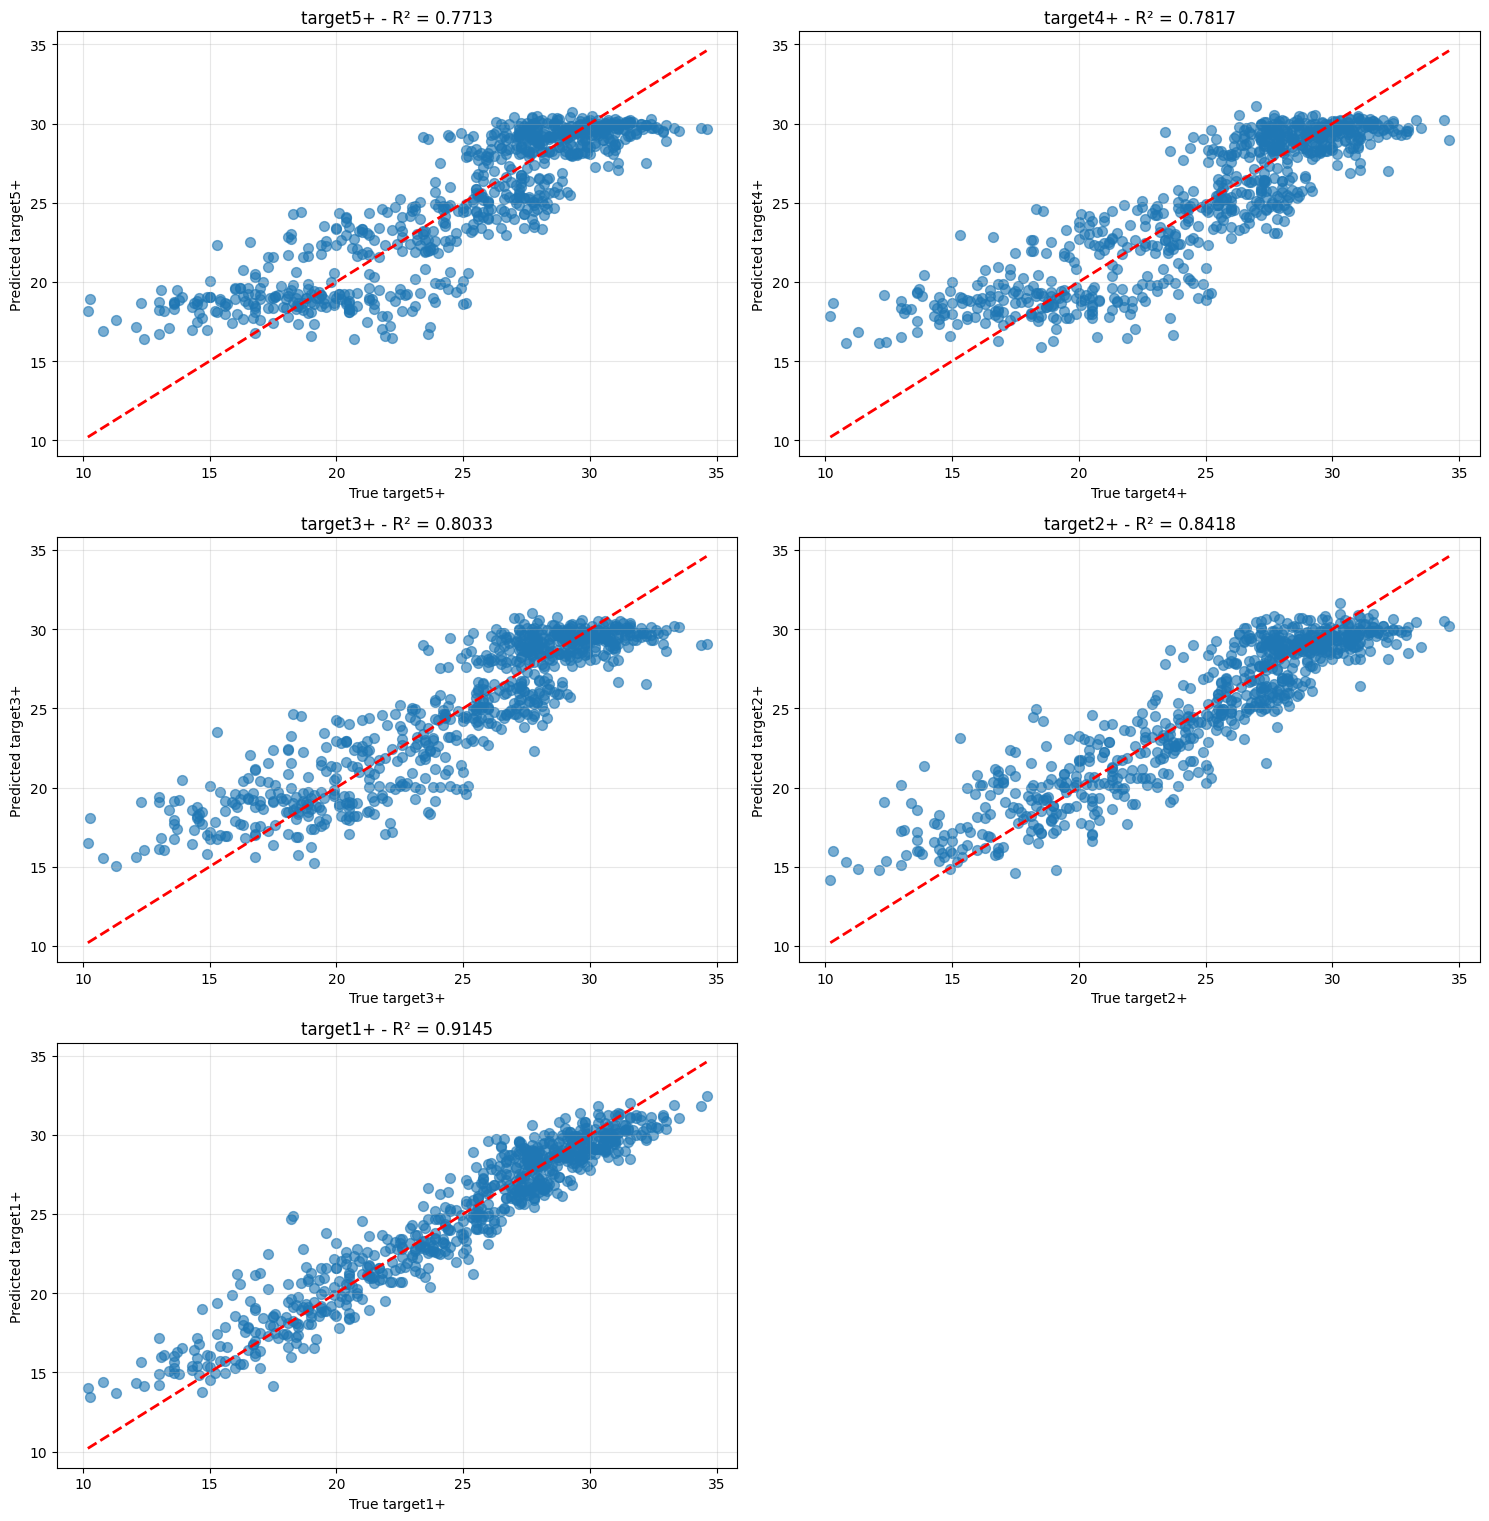

In [35]:
result = cat_boost_regression(
    X=X, 
    y=y,
    top_features=top_features,      # có thể None
    iterations=2000,
    depth=8,
    learning_rate=0.03,
    plot=True
)

## 6 Tunning Hyperparameter

In [49]:
def tuning_catboost_timeseries(
    X, y,
    top_features=None,
    n_trials=100,
    timeout=3600,
    val_ratio=0.2, 
    random_state=42,
    verbose=True
):
    """
    TUNING CATBOOST DÀNH RIÊNG CHO TIMESERIES
    - KHÔNG SHUFFLE
    - Validation = phần cuối cùng (chronological)
    - Early stopping + Optuna + Lưu model
    """
    print(f"TUNING CATBOOST TIMESERIES - {n_trials} trials / {timeout//60} phút")
    print("="*80)
    
    # === 1. Chia dữ liệu THEO THỜI GIAN (train = đầu, val = cuối) ===
    n_samples = len(X)
    split_idx = int(n_samples * (1 - val_ratio))
    
    X_train = X.iloc[:split_idx].copy()
    X_val   = X.iloc[split_idx:].copy()
    y_train = y.iloc[:split_idx].copy()
    y_val   = y.iloc[split_idx:].copy()
    
    if verbose:
        print(f"Train: {len(X_train):,} samples (t=0 → t={split_idx})")
        print(f"Val:   {len(X_val):,} samples (t={split_idx} → t={n_samples})")

    # === 2. Preprocessing (fit chỉ trên train!) ===
    # *** GIẢ ĐỊNH build_preprocessing_pipeline_catboost đã có ***
    try:
        preprocessor = build_preprocessing_pipeline_catboost(X_train)
        preprocessor.fit(X_train)

        X_train_proc = preprocessor.transform(X_train)
        X_val_proc   = preprocessor.transform(X_val)
        feature_names = preprocessor.get_feature_names_out()
    except NameError:
        print("Warning: build_preprocessing_pipeline_catboost không tìm thấy, bỏ qua preprocessing.")
        X_train_proc = X_train.values
        X_val_proc = X_val.values
        feature_names = X_train.columns.tolist()

    # Áp dụng top_features
    if top_features is not None:
        available = [f for f in top_features if f in feature_names]
        missing = len(top_features) - len(available)
        if missing > 0 and verbose:
            print(f"Warning: {missing}/{len(top_features)} top_features bị thiếu!")
        feature_names = available

    # Tạo DataFrame cuối
    X_train_final = pd.DataFrame(X_train_proc, columns=feature_names, index=X_train.index)[feature_names]
    X_val_final   = pd.DataFrame(X_val_proc,   columns=feature_names, index=X_val.index)[feature_names]
    
    # Cat features
    try:
        all_cat = preprocessor.named_transformers_['cat'].get_feature_names_out()
        cat_features = [f for f in all_cat if f in feature_names]
    except (NameError, KeyError):
        cat_features = []

    # Chuẩn bị y
    if isinstance(y_train, pd.Series):
        y_train_np = y_train.values
        y_val_np = y_val.values
    else:
        y_train_np = y_train.values
        y_val_np = y_val.values

    # === 3. Optuna Objective ===
    def objective(trial):
        # ... (Phần này giữ nguyên)
        params = {
            'iterations': trial.suggest_int('iterations', 800, 5000),
            'depth': trial.suggest_int('depth', 6, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 10.0),
            'border_count': trial.suggest_int('border_count', 128, 254),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
            'random_strength': trial.suggest_float('random_strength', 0.0, 5.0),
            'od_type': 'Iter',
            'early_stopping_rounds': 100,
            'use_best_model': True,
            'verbose': False,
            'random_seed': random_state,
            'loss_function': 'MultiRMSE' if y_train_np.ndim > 1 else 'RMSE',
            'cat_features': cat_features
        }
        
        model = cb.CatBoostRegressor(**params)
        
        model.fit(
            X_train_final, y_train_np,
            eval_set=(X_val_final, y_val_np),
            use_best_model=True,
            verbose=False
        )
        
        pred = model.predict(X_val_final)
        # Tính RMSE (mục tiêu tuning)
        if y_train_np.ndim > 1:
            rmse = np.mean([np.sqrt(mean_squared_error(y_val_np[:, i], pred[:, i])) 
                          for i in range(y_val_np.shape[1])])
        else:
            rmse = np.sqrt(mean_squared_error(y_val_np, pred))
        
        return rmse

    # === 4. CHẠY TUNING ===
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=random_state)
    )
    study.optimize(objective, n_trials=n_trials, timeout=timeout, show_progress_bar=True)

    # === 5. In kết quả Tuning Tốt nhất ===
    print(f"\nBEST VAL RMSE (sau {n_trials} trials): {study.best_value:.6f}")
    print("BEST PARAMS:")
    for k, v in study.best_params.items():
        print(f"  {k:20} = {v}")
    
    # --- Bổ sung tính R2 cho mô hình tốt nhất ---
    # ---------------------------------------------
    
    # === 6. Train model cuối cùng (dùng best params) ===
    final_params = study.best_params.copy()
    final_params.update({
        'od_type': 'Iter',
        'early_stopping_rounds': 150,
        'use_best_model': True,
        'verbose': 200,
        'random_seed': random_state,
        'loss_function': 'MultiRMSE' if y_train_np.ndim > 1 else 'RMSE',
        'cat_features': cat_features
    })
    
    final_model = cb.CatBoostRegressor(**final_params)
    print("\n" + "="*80)
    print("BẮT ĐẦU TRAIN MODEL CUỐI VỚI BEST PARAMS:")
    print("="*80)
    final_model.fit(
        X_train_final, y_train_np,
        eval_set=(X_val_final, y_val_np),
        use_best_model=True
    )
    
    # === 7. Tính lại RMSE và Bổ sung R2 trên Validation ===
    final_pred = final_model.predict(X_val_final)
    
    if y_train_np.ndim > 1:
        # Multi-output: Tính trung bình
        final_rmse = np.mean([np.sqrt(mean_squared_error(y_val_np[:, i], final_pred[:, i])) 
                            for i in range(y_val_np.shape[1])])
        final_r2 = np.mean([r2_score(y_val_np[:, i], final_pred[:, i]) 
                          for i in range(y_val_np.shape[1])])
    else:
        # Single-output
        final_rmse = np.sqrt(mean_squared_error(y_val_np, final_pred))
        final_r2 = r2_score(y_val_np, final_pred)

    # === 8. Lưu và In kết quả Cuối cùng ===
    result = {
        'model': final_model,
        'preprocessor': preprocessor,
        'best_params': final_params,
        'best_rmse': final_rmse, # Lưu kết quả RMSE của final model (có thể khác study.best_value)
        'best_r2': final_r2,     # BỔ SUNG R2
        'feature_names': feature_names,
        'val_idx_start': split_idx,
        'study': study
    }
    
    joblib.dump(result, 'BEST_CATBOOST_TIMESERIES.joblib')
    print(f"\nĐÃ LƯU → **BEST_CATBOOST_TIMESERIES.joblib**")
    print("-" * 30)
    print(f"🔥 RMSE trên Validation (phần cuối): **{final_rmse:.6f}**")
    print(f"📊 R-squared (R²) trên Validation: **{final_r2:.4f}**") # R2 thường được làm tròn đến 4 chữ số

    return result

In [50]:
# Đảm bảo X, y đã sort theo thời gian!
best_ts = tuning_catboost_timeseries(
    X=X.sort_index(),           # quan trọng: sort theo thời gian
    y=y.sort_index(),
    top_features=top_features,  # có thể None
    n_trials=80,
    timeout=3600,               # 1 tiếng
    val_ratio=0.2
)

TUNING CATBOOST TIMESERIES - 80 trials / 60 phút
Train: 2,895 samples (t=0 → t=2895)
Val:   724 samples (t=2895 → t=3619)
Numerical Features (783): ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'year', 'temp_range', 'day_length_hours', 'month_sin', 'month_cos', 'dayofyear_sin', 'dayofyear_cos', 'temp_solar_interaction', 'uv_temp_interaction', 'temp_cloudcover_interaction', 'temp_sealevelpressure_interaction', 'weighted_precip', 'effective_solar', 'precip_impact', 'wind_u', 'wind_v', 'moonphase_sin', 'moonphase_cos', 'tempmax_lag_1', 'tempmax_lag_2', 'tempmax_lag_3', 'tempmax_lag_5', 'tempmax_lag_7', 'tempmax_lag_10', 'tempmax_lag_14', 'tempmax_lag_21', 'tempmax_lag_30', 'tempmin_lag_1', 'tempmin_lag_2', 'tempmin_lag_3', 'tempmin_lag_5', 'tempmin_lag_7', 'tempmin_lag_10', 'tempmin_lag_

[I 2025-11-09 12:11:26,359] A new study created in memory with name: no-name-e173cec0-3535-4452-adda-65163387e593
Best trial: 0. Best value: 2.168:   1%|▏         | 1/80 [01:33<2:03:33, 93.84s/it, 93.84/3600 seconds]

[I 2025-11-09 12:13:00,204] Trial 0 finished with value: 2.168001250238094 and parameters: {'iterations': 2373, 'depth': 10, 'learning_rate': 0.08960785365368121, 'l2_leaf_reg': 7.190609389379256, 'border_count': 147, 'bagging_temperature': 0.15599452033620265, 'random_strength': 0.2904180608409973}. Best is trial 0 with value: 2.168001250238094.


Best trial: 1. Best value: 2.1282:   2%|▎         | 2/80 [02:35<1:37:09, 74.74s/it, 155.21/3600 seconds]

[I 2025-11-09 12:14:01,568] Trial 1 finished with value: 2.1282043624928493 and parameters: {'iterations': 4438, 'depth': 9, 'learning_rate': 0.08341106432362087, 'l2_leaf_reg': 3.144091460070617, 'border_count': 251, 'bagging_temperature': 0.8324426408004217, 'random_strength': 1.0616955533913808}. Best is trial 1 with value: 2.1282043624928493.


Best trial: 2. Best value: 2.07949:   4%|▍         | 3/80 [02:53<1:02:37, 48.79s/it, 173.13/3600 seconds]

[I 2025-11-09 12:14:19,487] Trial 2 finished with value: 2.0794887815506997 and parameters: {'iterations': 1563, 'depth': 6, 'learning_rate': 0.024878734419814436, 'l2_leaf_reg': 6.673295021425664, 'border_count': 182, 'bagging_temperature': 0.2912291401980419, 'random_strength': 3.0592644736118975}. Best is trial 2 with value: 2.0794887815506997.


Best trial: 2. Best value: 2.07949:   5%|▌         | 4/80 [03:25<53:30, 42.24s/it, 205.33/3600 seconds]  

[I 2025-11-09 12:14:51,687] Trial 3 finished with value: 2.1130352308600515 and parameters: {'iterations': 1386, 'depth': 7, 'learning_rate': 0.029967309097101588, 'l2_leaf_reg': 6.192489889519251, 'border_count': 227, 'bagging_temperature': 0.19967378215835974, 'random_strength': 2.571172192068058}. Best is trial 2 with value: 2.0794887815506997.


Best trial: 2. Best value: 2.07949:   6%|▋         | 5/80 [03:28<35:11, 28.16s/it, 208.51/3600 seconds]

[I 2025-11-09 12:14:54,871] Trial 4 finished with value: 2.135561315530934 and parameters: {'iterations': 3288, 'depth': 6, 'learning_rate': 0.061721159481070736, 'l2_leaf_reg': 4.193668865811041, 'border_count': 136, 'bagging_temperature': 0.9488855372533332, 'random_strength': 4.828160165372797}. Best is trial 2 with value: 2.0794887815506997.


Best trial: 2. Best value: 2.07949:   8%|▊         | 6/80 [04:11<40:45, 33.05s/it, 251.04/3600 seconds]

[I 2025-11-09 12:15:37,404] Trial 5 finished with value: 2.0890049363637737 and parameters: {'iterations': 4196, 'depth': 7, 'learning_rate': 0.013399060561509796, 'l2_leaf_reg': 7.789631185585098, 'border_count': 183, 'bagging_temperature': 0.12203823484477883, 'random_strength': 2.475884550556351}. Best is trial 2 with value: 2.0794887815506997.


Best trial: 2. Best value: 2.07949:   9%|▉         | 7/80 [09:59<2:45:51, 136.32s/it, 599.98/3600 seconds]

[I 2025-11-09 12:21:26,337] Trial 6 finished with value: 2.145011222876737 and parameters: {'iterations': 944, 'depth': 10, 'learning_rate': 0.02171103454376615, 'l2_leaf_reg': 7.637655990477874, 'border_count': 167, 'bagging_temperature': 0.5200680211778108, 'random_strength': 2.7335513967163982}. Best is trial 2 with value: 2.0794887815506997.


Best trial: 2. Best value: 2.07949:  10%|█         | 8/80 [13:44<3:17:08, 164.29s/it, 824.16/3600 seconds]

[I 2025-11-09 12:25:10,504] Trial 7 finished with value: 2.14062515083888 and parameters: {'iterations': 1576, 'depth': 10, 'learning_rate': 0.10196967939171485, 'l2_leaf_reg': 9.576492590949325, 'border_count': 241, 'bagging_temperature': 0.5978999788110851, 'random_strength': 4.609371175115584}. Best is trial 2 with value: 2.0794887815506997.


Best trial: 2. Best value: 2.07949:  11%|█▏        | 9/80 [13:59<2:19:25, 117.82s/it, 839.81/3600 seconds]

[I 2025-11-09 12:25:26,173] Trial 8 finished with value: 2.0845253751594557 and parameters: {'iterations': 1171, 'depth': 6, 'learning_rate': 0.011450964268326641, 'l2_leaf_reg': 5.277312315342851, 'border_count': 177, 'bagging_temperature': 0.2713490317738959, 'random_strength': 4.143687545759647}. Best is trial 2 with value: 2.0794887815506997.


Best trial: 2. Best value: 2.07949:  12%|█▎        | 10/80 [14:20<1:42:28, 87.84s/it, 860.51/3600 seconds]

[I 2025-11-09 12:25:46,872] Trial 9 finished with value: 2.0973345496224836 and parameters: {'iterations': 2298, 'depth': 7, 'learning_rate': 0.05082341959721458, 'l2_leaf_reg': 3.9864695748233387, 'border_count': 229, 'bagging_temperature': 0.07455064367977082, 'random_strength': 4.9344346830025865}. Best is trial 2 with value: 2.0794887815506997.


Best trial: 2. Best value: 2.07949:  14%|█▍        | 11/80 [14:42<1:17:46, 67.63s/it, 882.31/3600 seconds]

[I 2025-11-09 12:26:08,670] Trial 10 finished with value: 2.124981269732761 and parameters: {'iterations': 2957, 'depth': 8, 'learning_rate': 0.18255631599020644, 'l2_leaf_reg': 9.171755156296214, 'border_count': 209, 'bagging_temperature': 0.37239267954698246, 'random_strength': 3.573116210230396}. Best is trial 2 with value: 2.0794887815506997.


Best trial: 2. Best value: 2.07949:  15%|█▌        | 12/80 [14:54<57:32, 50.77s/it, 894.53/3600 seconds]  

[I 2025-11-09 12:26:20,888] Trial 11 finished with value: 2.1127139278683145 and parameters: {'iterations': 850, 'depth': 6, 'learning_rate': 0.01012826296702332, 'l2_leaf_reg': 5.863895218183, 'border_count': 187, 'bagging_temperature': 0.3203181997429707, 'random_strength': 3.723229192334017}. Best is trial 2 with value: 2.0794887815506997.


Best trial: 2. Best value: 2.07949:  16%|█▋        | 13/80 [15:07<43:57, 39.37s/it, 907.66/3600 seconds]

[I 2025-11-09 12:26:34,022] Trial 12 finished with value: 2.1030853084872474 and parameters: {'iterations': 1901, 'depth': 6, 'learning_rate': 0.01943781612918001, 'l2_leaf_reg': 5.24764199701704, 'border_count': 163, 'bagging_temperature': 0.35716521934347706, 'random_strength': 3.6658712610292055}. Best is trial 2 with value: 2.0794887815506997.


Best trial: 2. Best value: 2.07949:  18%|█▊        | 14/80 [16:17<53:25, 48.56s/it, 977.48/3600 seconds]

[I 2025-11-09 12:27:43,834] Trial 13 finished with value: 2.1141950217785066 and parameters: {'iterations': 3696, 'depth': 8, 'learning_rate': 0.03126716208402543, 'l2_leaf_reg': 5.433434013476078, 'border_count': 201, 'bagging_temperature': 0.009295155085794815, 'random_strength': 1.7139964413315822}. Best is trial 2 with value: 2.0794887815506997.


Best trial: 14. Best value: 2.0779:  19%|█▉        | 15/80 [16:35<42:30, 39.24s/it, 995.11/3600 seconds]

[I 2025-11-09 12:28:01,469] Trial 14 finished with value: 2.0779041747083027 and parameters: {'iterations': 2284, 'depth': 6, 'learning_rate': 0.01584732716277187, 'l2_leaf_reg': 6.874228298977626, 'border_count': 171, 'bagging_temperature': 0.6634064286119826, 'random_strength': 4.047894591765571}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  20%|██        | 16/80 [17:07<39:48, 37.32s/it, 1027.96/3600 seconds]

[I 2025-11-09 12:28:34,318] Trial 15 finished with value: 2.0855158078386142 and parameters: {'iterations': 2325, 'depth': 7, 'learning_rate': 0.018510855371106066, 'l2_leaf_reg': 8.65646224113015, 'border_count': 154, 'bagging_temperature': 0.6866548980401576, 'random_strength': 2.961191979187319}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  21%|██▏       | 17/80 [17:19<31:04, 29.60s/it, 1039.60/3600 seconds]

[I 2025-11-09 12:28:45,961] Trial 16 finished with value: 2.103064993948566 and parameters: {'iterations': 1901, 'depth': 6, 'learning_rate': 0.03651889580406705, 'l2_leaf_reg': 6.845102409330796, 'border_count': 202, 'bagging_temperature': 0.699827592760739, 'random_strength': 1.8698885287079228}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  22%|██▎       | 18/80 [20:53<1:27:48, 84.98s/it, 1253.50/3600 seconds]

[I 2025-11-09 12:32:19,860] Trial 17 finished with value: 2.107580307876689 and parameters: {'iterations': 2853, 'depth': 9, 'learning_rate': 0.015207562018838019, 'l2_leaf_reg': 8.327426432984156, 'border_count': 171, 'bagging_temperature': 0.4508204508711363, 'random_strength': 3.197342331354388}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  24%|██▍       | 19/80 [21:17<1:07:44, 66.63s/it, 1277.39/3600 seconds]

[I 2025-11-09 12:32:43,745] Trial 18 finished with value: 2.1059274014811074 and parameters: {'iterations': 1820, 'depth': 7, 'learning_rate': 0.026712758715123245, 'l2_leaf_reg': 6.612200470791645, 'border_count': 128, 'bagging_temperature': 0.7991366252047726, 'random_strength': 4.26637945339307}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  25%|██▌       | 20/80 [22:13<1:03:32, 63.54s/it, 1333.72/3600 seconds]

[I 2025-11-09 12:33:40,077] Trial 19 finished with value: 2.097695057145568 and parameters: {'iterations': 2689, 'depth': 8, 'learning_rate': 0.043590842293923175, 'l2_leaf_reg': 4.578961945132128, 'border_count': 215, 'bagging_temperature': 0.5400950201135937, 'random_strength': 4.074177944057478}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  26%|██▋       | 21/80 [22:25<47:20, 48.14s/it, 1345.95/3600 seconds]  

[I 2025-11-09 12:33:52,310] Trial 20 finished with value: 2.1013524931644065 and parameters: {'iterations': 3386, 'depth': 6, 'learning_rate': 0.02343627727925559, 'l2_leaf_reg': 7.6745471470886475, 'border_count': 195, 'bagging_temperature': 0.4327456111804914, 'random_strength': 2.0152619708254145}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  28%|██▊       | 22/80 [22:43<37:42, 39.00s/it, 1363.65/3600 seconds]

[I 2025-11-09 12:34:10,009] Trial 21 finished with value: 2.0834949535726004 and parameters: {'iterations': 1314, 'depth': 6, 'learning_rate': 0.011844626774143486, 'l2_leaf_reg': 5.134892049677064, 'border_count': 179, 'bagging_temperature': 0.26089994198253386, 'random_strength': 4.197015114133539}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  29%|██▉       | 23/80 [22:58<30:05, 31.68s/it, 1378.24/3600 seconds]

[I 2025-11-09 12:34:24,595] Trial 22 finished with value: 2.096907461672374 and parameters: {'iterations': 4964, 'depth': 6, 'learning_rate': 0.015170452323586749, 'l2_leaf_reg': 5.971511082017651, 'border_count': 156, 'bagging_temperature': 0.25447980371904605, 'random_strength': 3.286056990721321}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  30%|███       | 24/80 [23:53<36:16, 38.87s/it, 1433.90/3600 seconds]

[I 2025-11-09 12:35:20,256] Trial 23 finished with value: 2.0939018623624586 and parameters: {'iterations': 1450, 'depth': 7, 'learning_rate': 0.017022968281446768, 'l2_leaf_reg': 6.890141515495215, 'border_count': 179, 'bagging_temperature': 0.6472689953816586, 'random_strength': 4.365712142609362}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  31%|███▏      | 25/80 [24:19<31:55, 34.82s/it, 1459.27/3600 seconds]

[I 2025-11-09 12:35:45,625] Trial 24 finished with value: 2.084477470732252 and parameters: {'iterations': 2005, 'depth': 6, 'learning_rate': 0.012197416810456128, 'l2_leaf_reg': 4.742025652129715, 'border_count': 190, 'bagging_temperature': 0.4299745589163554, 'random_strength': 3.890926376462471}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  32%|███▎      | 26/80 [24:56<32:04, 35.65s/it, 1496.84/3600 seconds]

[I 2025-11-09 12:36:23,202] Trial 25 finished with value: 2.1069343765827746 and parameters: {'iterations': 1198, 'depth': 7, 'learning_rate': 0.010201816599873714, 'l2_leaf_reg': 6.342650933879381, 'border_count': 145, 'bagging_temperature': 0.20363185325829564, 'random_strength': 3.336767345087437}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  34%|███▍      | 27/80 [25:08<25:15, 28.60s/it, 1508.99/3600 seconds]

[I 2025-11-09 12:36:35,352] Trial 26 finished with value: 2.0844203318159127 and parameters: {'iterations': 1647, 'depth': 6, 'learning_rate': 0.024137261027605328, 'l2_leaf_reg': 3.2290674080257142, 'border_count': 173, 'bagging_temperature': 0.7726504975791996, 'random_strength': 4.505746513728619}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  35%|███▌      | 28/80 [26:06<32:24, 37.39s/it, 1566.89/3600 seconds]

[I 2025-11-09 12:37:33,248] Trial 27 finished with value: 2.090557731709142 and parameters: {'iterations': 2234, 'depth': 7, 'learning_rate': 0.01372756297379294, 'l2_leaf_reg': 5.715519149984652, 'border_count': 162, 'bagging_temperature': 0.9275916119933421, 'random_strength': 2.9251863576452717}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  36%|███▋      | 29/80 [27:41<46:29, 54.70s/it, 1661.99/3600 seconds]

[I 2025-11-09 12:39:08,351] Trial 28 finished with value: 2.1053542888097345 and parameters: {'iterations': 1145, 'depth': 8, 'learning_rate': 0.01779430887771382, 'l2_leaf_reg': 7.306411397332003, 'border_count': 197, 'bagging_temperature': 0.5826101491921469, 'random_strength': 2.234498030876462}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  38%|███▊      | 30/80 [27:47<33:12, 39.85s/it, 1667.18/3600 seconds]

[I 2025-11-09 12:39:13,543] Trial 29 finished with value: 2.1123703496093835 and parameters: {'iterations': 2608, 'depth': 6, 'learning_rate': 0.036883500913014775, 'l2_leaf_reg': 7.154508514417038, 'border_count': 144, 'bagging_temperature': 0.13051080635059148, 'random_strength': 1.5082553784369295}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 14. Best value: 2.0779:  39%|███▉      | 31/80 [30:00<55:22, 67.81s/it, 1800.24/3600 seconds]

[I 2025-11-09 12:41:26,599] Trial 30 finished with value: 2.1517329815476307 and parameters: {'iterations': 2106, 'depth': 9, 'learning_rate': 0.02039497833031379, 'l2_leaf_reg': 8.381899033559211, 'border_count': 156, 'bagging_temperature': 0.27167526617160814, 'random_strength': 0.11002168481556573}. Best is trial 14 with value: 2.0779041747083027.


Best trial: 31. Best value: 2.06963:  40%|████      | 32/80 [30:15<41:38, 52.05s/it, 1815.51/3600 seconds]

[I 2025-11-09 12:41:41,866] Trial 31 finished with value: 2.0696286189486672 and parameters: {'iterations': 1655, 'depth': 6, 'learning_rate': 0.024994649547925116, 'l2_leaf_reg': 3.8856588255986497, 'border_count': 176, 'bagging_temperature': 0.8311616655087293, 'random_strength': 4.50015309381805}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  41%|████▏     | 33/80 [30:25<30:53, 39.44s/it, 1825.52/3600 seconds]

[I 2025-11-09 12:41:51,880] Trial 32 finished with value: 2.0850762866478427 and parameters: {'iterations': 1637, 'depth': 6, 'learning_rate': 0.028213371254397414, 'l2_leaf_reg': 3.808450630406525, 'border_count': 183, 'bagging_temperature': 0.8469609465598744, 'random_strength': 4.733235374565574}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  42%|████▎     | 34/80 [30:39<24:23, 31.81s/it, 1839.54/3600 seconds]

[I 2025-11-09 12:42:05,900] Trial 33 finished with value: 2.0956919235709774 and parameters: {'iterations': 1367, 'depth': 6, 'learning_rate': 0.015318513143025469, 'l2_leaf_reg': 3.4875862258378048, 'border_count': 170, 'bagging_temperature': 0.8902594158241256, 'random_strength': 0.6714190239818809}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  44%|████▍     | 35/80 [31:03<22:06, 29.48s/it, 1863.56/3600 seconds]

[I 2025-11-09 12:42:29,923] Trial 34 finished with value: 2.0906623803113265 and parameters: {'iterations': 2461, 'depth': 7, 'learning_rate': 0.03144537246306546, 'l2_leaf_reg': 4.583088105015021, 'border_count': 188, 'bagging_temperature': 0.7083349335953683, 'random_strength': 4.0085530001204175}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  45%|████▌     | 36/80 [31:10<16:34, 22.60s/it, 1870.11/3600 seconds]

[I 2025-11-09 12:42:36,465] Trial 35 finished with value: 2.104880599714069 and parameters: {'iterations': 1009, 'depth': 6, 'learning_rate': 0.07080223339503723, 'l2_leaf_reg': 4.955638409426078, 'border_count': 177, 'bagging_temperature': 0.7471600692690492, 'random_strength': 4.448803656845498}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  46%|████▋     | 37/80 [31:47<19:18, 26.95s/it, 1907.22/3600 seconds]

[I 2025-11-09 12:43:13,580] Trial 36 finished with value: 2.098084139943494 and parameters: {'iterations': 1720, 'depth': 7, 'learning_rate': 0.013505308186318964, 'l2_leaf_reg': 6.385063358058128, 'border_count': 163, 'bagging_temperature': 0.2004014860385544, 'random_strength': 3.444359783102316}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  48%|████▊     | 38/80 [32:01<16:07, 23.04s/it, 1921.14/3600 seconds]

[I 2025-11-09 12:43:27,497] Trial 37 finished with value: 2.0836560736899044 and parameters: {'iterations': 1476, 'depth': 6, 'learning_rate': 0.024098825912523915, 'l2_leaf_reg': 4.071457111117703, 'border_count': 210, 'bagging_temperature': 0.9982835861660029, 'random_strength': 4.992483437747102}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  49%|████▉     | 39/80 [34:11<37:50, 55.37s/it, 2051.94/3600 seconds]

[I 2025-11-09 12:45:38,297] Trial 38 finished with value: 2.106200896878274 and parameters: {'iterations': 801, 'depth': 9, 'learning_rate': 0.039745515059504834, 'l2_leaf_reg': 4.291486507758401, 'border_count': 183, 'bagging_temperature': 0.6162222835245268, 'random_strength': 3.7740087004194858}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  50%|█████     | 40/80 [34:16<26:44, 40.11s/it, 2056.43/3600 seconds]

[I 2025-11-09 12:45:42,793] Trial 39 finished with value: 2.1135138941796683 and parameters: {'iterations': 2123, 'depth': 6, 'learning_rate': 0.053691338572169796, 'l2_leaf_reg': 3.5725398835297577, 'border_count': 151, 'bagging_temperature': 0.4886531227726453, 'random_strength': 4.213520570543378}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  51%|█████▏    | 41/80 [35:35<33:39, 51.79s/it, 2135.49/3600 seconds]

[I 2025-11-09 12:47:01,847] Trial 40 finished with value: 2.1033691843940874 and parameters: {'iterations': 1352, 'depth': 7, 'learning_rate': 0.011801786423949702, 'l2_leaf_reg': 5.513075594771697, 'border_count': 221, 'bagging_temperature': 0.8455662216381731, 'random_strength': 2.5126691033654027}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  52%|█████▎    | 42/80 [35:52<26:13, 41.40s/it, 2152.65/3600 seconds]

[I 2025-11-09 12:47:19,014] Trial 41 finished with value: 2.094289992174265 and parameters: {'iterations': 1493, 'depth': 6, 'learning_rate': 0.02384956596115559, 'l2_leaf_reg': 4.411406636292126, 'border_count': 253, 'bagging_temperature': 0.990515216384425, 'random_strength': 4.804263374110751}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  54%|█████▍    | 43/80 [36:10<21:11, 34.37s/it, 2170.60/3600 seconds]

[I 2025-11-09 12:47:36,964] Trial 42 finished with value: 2.083292724345475 and parameters: {'iterations': 1197, 'depth': 6, 'learning_rate': 0.021312088464733907, 'l2_leaf_reg': 3.958963405565163, 'border_count': 207, 'bagging_temperature': 0.9884198227105649, 'random_strength': 4.993339049979491}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  55%|█████▌    | 44/80 [36:30<17:58, 29.95s/it, 2190.24/3600 seconds]

[I 2025-11-09 12:47:56,598] Trial 43 finished with value: 2.078635335632381 and parameters: {'iterations': 1073, 'depth': 6, 'learning_rate': 0.016192307151837164, 'l2_leaf_reg': 5.0220286394537546, 'border_count': 236, 'bagging_temperature': 0.916532869566244, 'random_strength': 4.613255622575019}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  56%|█████▋    | 45/80 [36:49<15:41, 26.89s/it, 2209.99/3600 seconds]

[I 2025-11-09 12:48:16,346] Trial 44 finished with value: 2.080311231795556 and parameters: {'iterations': 1063, 'depth': 6, 'learning_rate': 0.020802265891448457, 'l2_leaf_reg': 3.072998871444894, 'border_count': 240, 'bagging_temperature': 0.8981637381880241, 'random_strength': 4.748626758598032}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  57%|█████▊    | 46/80 [37:06<13:32, 23.89s/it, 2226.89/3600 seconds]

[I 2025-11-09 12:48:33,247] Trial 45 finished with value: 2.0791294971428895 and parameters: {'iterations': 924, 'depth': 6, 'learning_rate': 0.01721422140130507, 'l2_leaf_reg': 3.218205853275554, 'border_count': 237, 'bagging_temperature': 0.8904379393801161, 'random_strength': 4.6492212193822535}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  59%|█████▉    | 47/80 [37:11<09:58, 18.13s/it, 2231.58/3600 seconds]

[I 2025-11-09 12:48:37,929] Trial 46 finished with value: 2.136595213739414 and parameters: {'iterations': 954, 'depth': 6, 'learning_rate': 0.10240044730001842, 'l2_leaf_reg': 3.4896265373408912, 'border_count': 243, 'bagging_temperature': 0.8170244335475946, 'random_strength': 4.590776669243487}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  60%|██████    | 48/80 [38:46<21:58, 41.19s/it, 2326.57/3600 seconds]

[I 2025-11-09 12:50:12,913] Trial 47 finished with value: 2.0972499611473188 and parameters: {'iterations': 1783, 'depth': 7, 'learning_rate': 0.015807370355492366, 'l2_leaf_reg': 6.082534511071587, 'border_count': 231, 'bagging_temperature': 0.8958972419382322, 'random_strength': 4.556675279624629}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  61%|██████▏   | 49/80 [38:57<16:37, 32.16s/it, 2337.67/3600 seconds]

[I 2025-11-09 12:50:24,032] Trial 48 finished with value: 2.095355132017575 and parameters: {'iterations': 1989, 'depth': 6, 'learning_rate': 0.032780222403565804, 'l2_leaf_reg': 7.923424780798692, 'border_count': 246, 'bagging_temperature': 0.9513687615512737, 'random_strength': 3.9281871586010166}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  62%|██████▎   | 50/80 [39:46<18:39, 37.31s/it, 2386.98/3600 seconds]

[I 2025-11-09 12:51:13,344] Trial 49 finished with value: 2.1037427760364635 and parameters: {'iterations': 815, 'depth': 7, 'learning_rate': 0.017020620624623364, 'l2_leaf_reg': 7.370998554888841, 'border_count': 230, 'bagging_temperature': 0.7523489309928054, 'random_strength': 3.590890319811593}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  64%|██████▍   | 51/80 [40:02<14:51, 30.75s/it, 2402.42/3600 seconds]

[I 2025-11-09 12:51:28,779] Trial 50 finished with value: 2.094655960636241 and parameters: {'iterations': 3021, 'depth': 6, 'learning_rate': 0.02746709539265587, 'l2_leaf_reg': 6.640518966350405, 'border_count': 224, 'bagging_temperature': 0.8665157172724123, 'random_strength': 3.0596093098734665}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  65%|██████▌   | 52/80 [40:22<12:53, 27.62s/it, 2422.75/3600 seconds]

[I 2025-11-09 12:51:49,112] Trial 51 finished with value: 2.0886412062942155 and parameters: {'iterations': 1046, 'depth': 6, 'learning_rate': 0.02004938152349843, 'l2_leaf_reg': 3.263897463994189, 'border_count': 250, 'bagging_temperature': 0.9037312993304703, 'random_strength': 4.7666403306246945}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  66%|██████▋   | 53/80 [40:37<10:45, 23.90s/it, 2437.97/3600 seconds]

[I 2025-11-09 12:52:04,331] Trial 52 finished with value: 2.0824124300032505 and parameters: {'iterations': 1184, 'depth': 6, 'learning_rate': 0.018921062021514286, 'l2_leaf_reg': 3.013465722500144, 'border_count': 234, 'bagging_temperature': 0.9447786899636859, 'random_strength': 4.381611467719224}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  68%|██████▊   | 54/80 [40:41<07:40, 17.72s/it, 2441.25/3600 seconds]

[I 2025-11-09 12:52:07,614] Trial 53 finished with value: 2.103753612071668 and parameters: {'iterations': 1010, 'depth': 6, 'learning_rate': 0.19661499265012916, 'l2_leaf_reg': 3.668089858157855, 'border_count': 237, 'bagging_temperature': 0.7925027843817113, 'random_strength': 4.606241533355822}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  69%|██████▉   | 55/80 [41:09<08:42, 20.90s/it, 2469.59/3600 seconds]

[I 2025-11-09 12:52:35,948] Trial 54 finished with value: 2.074941109248454 and parameters: {'iterations': 1613, 'depth': 6, 'learning_rate': 0.013748630956168937, 'l2_leaf_reg': 3.3171384317927117, 'border_count': 238, 'bagging_temperature': 0.7250837818504391, 'random_strength': 4.720677833923236}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  70%|███████   | 56/80 [41:39<09:28, 23.70s/it, 2499.80/3600 seconds]

[I 2025-11-09 12:53:06,163] Trial 55 finished with value: 2.080443688134347 and parameters: {'iterations': 1550, 'depth': 6, 'learning_rate': 0.012753798355735108, 'l2_leaf_reg': 3.3143020045396567, 'border_count': 247, 'bagging_temperature': 0.6524850071853842, 'random_strength': 4.1706880220070595}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  71%|███████▏  | 57/80 [42:56<15:07, 39.47s/it, 2576.07/3600 seconds]

[I 2025-11-09 12:54:22,431] Trial 56 finished with value: 2.0999783319433143 and parameters: {'iterations': 1313, 'depth': 7, 'learning_rate': 0.014176662667548712, 'l2_leaf_reg': 3.8527650656971577, 'border_count': 224, 'bagging_temperature': 0.7148088620981274, 'random_strength': 2.764652832871051}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  72%|███████▎  | 58/80 [43:24<13:12, 36.02s/it, 2604.04/3600 seconds]

[I 2025-11-09 12:54:50,402] Trial 57 finished with value: 2.085214372221588 and parameters: {'iterations': 2426, 'depth': 6, 'learning_rate': 0.01065822211424315, 'l2_leaf_reg': 6.927133597225296, 'border_count': 217, 'bagging_temperature': 0.5454327126444237, 'random_strength': 4.306059066923935}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  74%|███████▍  | 59/80 [51:45<1:01:25, 175.50s/it, 3105.00/3600 seconds]

[I 2025-11-09 13:03:11,360] Trial 58 finished with value: 2.124548776218417 and parameters: {'iterations': 1878, 'depth': 10, 'learning_rate': 0.016354344604001043, 'l2_leaf_reg': 4.138919421001699, 'border_count': 194, 'bagging_temperature': 0.049329028464301095, 'random_strength': 3.891367584120978}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  75%|███████▌  | 60/80 [51:56<42:07, 126.36s/it, 3116.69/3600 seconds]  

[I 2025-11-09 13:03:23,048] Trial 59 finished with value: 2.090221585132708 and parameters: {'iterations': 1692, 'depth': 6, 'learning_rate': 0.018298171656887262, 'l2_leaf_reg': 4.825617161833864, 'border_count': 166, 'bagging_temperature': 0.6661447567840119, 'random_strength': 4.847779922418687}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  76%|███████▋  | 61/80 [52:35<31:41, 100.09s/it, 3155.49/3600 seconds]

[I 2025-11-09 13:04:01,850] Trial 60 finished with value: 2.092427928603536 and parameters: {'iterations': 2144, 'depth': 7, 'learning_rate': 0.014858177879894248, 'l2_leaf_reg': 5.7355025776295685, 'border_count': 174, 'bagging_temperature': 0.7864907829800858, 'random_strength': 4.069648877937176}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  78%|███████▊  | 62/80 [52:51<22:26, 74.81s/it, 3171.32/3600 seconds] 

[I 2025-11-09 13:04:17,683] Trial 61 finished with value: 2.0847364238980224 and parameters: {'iterations': 1108, 'depth': 6, 'learning_rate': 0.021868950818513685, 'l2_leaf_reg': 3.0034549062288494, 'border_count': 241, 'bagging_temperature': 0.8705012604885961, 'random_strength': 4.4234156761357655}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  79%|███████▉  | 63/80 [53:06<16:08, 56.98s/it, 3186.69/3600 seconds]

[I 2025-11-09 13:04:33,050] Trial 62 finished with value: 2.0894959719840838 and parameters: {'iterations': 3874, 'depth': 6, 'learning_rate': 0.02244445817264979, 'l2_leaf_reg': 3.363578663367714, 'border_count': 238, 'bagging_temperature': 0.8303876501384756, 'random_strength': 4.7224013019668645}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  80%|████████  | 64/80 [53:22<11:52, 44.53s/it, 3202.18/3600 seconds]

[I 2025-11-09 13:04:48,533] Trial 63 finished with value: 2.0791429341274226 and parameters: {'iterations': 1544, 'depth': 6, 'learning_rate': 0.025572235908615328, 'l2_leaf_reg': 3.79069871183502, 'border_count': 235, 'bagging_temperature': 0.7371916478086177, 'random_strength': 4.6738192205067435}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  81%|████████▏ | 65/80 [53:37<08:56, 35.75s/it, 3217.44/3600 seconds]

[I 2025-11-09 13:05:03,800] Trial 64 finished with value: 2.087859971790564 and parameters: {'iterations': 1318, 'depth': 6, 'learning_rate': 0.026134764639946507, 'l2_leaf_reg': 3.6742918815589007, 'border_count': 233, 'bagging_temperature': 0.763051353759115, 'random_strength': 4.587743338892901}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  82%|████████▎ | 66/80 [53:47<06:31, 27.98s/it, 3227.29/3600 seconds]

[I 2025-11-09 13:05:13,652] Trial 65 finished with value: 2.0914953081549035 and parameters: {'iterations': 1519, 'depth': 6, 'learning_rate': 0.03562065455301299, 'l2_leaf_reg': 4.4368966963951255, 'border_count': 225, 'bagging_temperature': 0.34391346194224215, 'random_strength': 1.2994981301785136}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  84%|████████▍ | 67/80 [54:07<05:31, 25.52s/it, 3247.07/3600 seconds]

[I 2025-11-09 13:05:33,434] Trial 66 finished with value: 2.131957290413264 and parameters: {'iterations': 1652, 'depth': 8, 'learning_rate': 0.14629682191282417, 'l2_leaf_reg': 3.8505611220059572, 'border_count': 184, 'bagging_temperature': 0.725923804860888, 'random_strength': 4.28897751381144}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  85%|████████▌ | 68/80 [54:27<04:49, 24.11s/it, 3267.89/3600 seconds]

[I 2025-11-09 13:05:54,250] Trial 67 finished with value: 2.0780418473247235 and parameters: {'iterations': 1914, 'depth': 6, 'learning_rate': 0.017503591865566354, 'l2_leaf_reg': 5.100725006230198, 'border_count': 236, 'bagging_temperature': 0.6162720064881297, 'random_strength': 3.7611980670438214}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  86%|████████▋ | 69/80 [54:57<04:41, 25.61s/it, 3297.01/3600 seconds]

[I 2025-11-09 13:06:23,352] Trial 68 finished with value: 2.08926700857405 and parameters: {'iterations': 1965, 'depth': 6, 'learning_rate': 0.012845500091599052, 'l2_leaf_reg': 5.159074370233987, 'border_count': 246, 'bagging_temperature': 0.6946036172001677, 'random_strength': 3.805148590470811}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  88%|████████▊ | 70/80 [55:19<04:05, 24.59s/it, 3319.22/3600 seconds]

[I 2025-11-09 13:06:45,583] Trial 69 finished with value: 2.095183683628779 and parameters: {'iterations': 1756, 'depth': 6, 'learning_rate': 0.010881243869358907, 'l2_leaf_reg': 4.6674769385639365, 'border_count': 236, 'bagging_temperature': 0.6001123015251933, 'random_strength': 4.097413486674592}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  89%|████████▉ | 71/80 [55:39<03:29, 23.27s/it, 3339.39/3600 seconds]

[I 2025-11-09 13:07:05,752] Trial 70 finished with value: 2.0850560502995648 and parameters: {'iterations': 2342, 'depth': 6, 'learning_rate': 0.017356878666525036, 'l2_leaf_reg': 4.247838910160173, 'border_count': 228, 'bagging_temperature': 0.6167248131235966, 'random_strength': 4.444199941549574}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  90%|█████████ | 72/80 [55:58<02:56, 22.10s/it, 3358.76/3600 seconds]

[I 2025-11-09 13:07:25,117] Trial 71 finished with value: 2.088504777632574 and parameters: {'iterations': 1869, 'depth': 6, 'learning_rate': 0.02532096623107747, 'l2_leaf_reg': 6.221272577377849, 'border_count': 220, 'bagging_temperature': 0.5746242843323351, 'random_strength': 3.4935939678089087}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  91%|█████████▏| 73/80 [56:08<02:08, 18.29s/it, 3368.16/3600 seconds]

[I 2025-11-09 13:07:34,517] Trial 72 finished with value: 2.0999787124169758 and parameters: {'iterations': 1430, 'depth': 6, 'learning_rate': 0.029448585286029987, 'l2_leaf_reg': 5.3878565226392805, 'border_count': 170, 'bagging_temperature': 0.4883837097224771, 'random_strength': 2.2881198918077867}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  92%|█████████▎| 74/80 [56:29<01:55, 19.28s/it, 3389.72/3600 seconds]

[I 2025-11-09 13:07:56,083] Trial 73 finished with value: 2.094315221121922 and parameters: {'iterations': 1277, 'depth': 6, 'learning_rate': 0.01881482217253173, 'l2_leaf_reg': 9.985323037015249, 'border_count': 243, 'bagging_temperature': 0.6757633037490592, 'random_strength': 4.886382417816545}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  94%|█████████▍| 75/80 [56:49<01:37, 19.54s/it, 3409.91/3600 seconds]

[I 2025-11-09 13:08:16,267] Trial 74 finished with value: 2.072605094506563 and parameters: {'iterations': 2626, 'depth': 6, 'learning_rate': 0.013541444753651915, 'l2_leaf_reg': 6.475779788884394, 'border_count': 179, 'bagging_temperature': 0.8109771840938038, 'random_strength': 4.00426938998549}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  95%|█████████▌| 76/80 [57:18<01:28, 22.13s/it, 3438.06/3600 seconds]

[I 2025-11-09 13:08:44,417] Trial 75 finished with value: 2.0819296492814865 and parameters: {'iterations': 2662, 'depth': 6, 'learning_rate': 0.014270691536536845, 'l2_leaf_reg': 4.947799622905285, 'border_count': 249, 'bagging_temperature': 0.8119164093453282, 'random_strength': 4.669480297736523}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  96%|█████████▋| 77/80 [57:36<01:03, 21.06s/it, 3456.62/3600 seconds]

[I 2025-11-09 13:09:02,967] Trial 76 finished with value: 2.077050878598362 and parameters: {'iterations': 2189, 'depth': 6, 'learning_rate': 0.015885810128994225, 'l2_leaf_reg': 7.073974434595945, 'border_count': 179, 'bagging_temperature': 0.7307512951199572, 'random_strength': 3.969173722091544}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  98%|█████████▊| 78/80 [58:33<01:03, 31.74s/it, 3513.27/3600 seconds]

[I 2025-11-09 13:09:59,634] Trial 77 finished with value: 2.088487651047786 and parameters: {'iterations': 2554, 'depth': 7, 'learning_rate': 0.011425391258251077, 'l2_leaf_reg': 7.9530973539992615, 'border_count': 175, 'bagging_temperature': 0.85976525383877, 'random_strength': 3.6724361452526786}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963:  99%|█████████▉| 79/80 [58:53<00:28, 28.37s/it, 3533.79/3600 seconds]

[I 2025-11-09 13:10:20,150] Trial 78 finished with value: 2.0726780712548356 and parameters: {'iterations': 2882, 'depth': 6, 'learning_rate': 0.013648396889472858, 'l2_leaf_reg': 7.146076456023058, 'border_count': 180, 'bagging_temperature': 0.6331260095834308, 'random_strength': 3.9814451046204695}. Best is trial 31 with value: 2.0696286189486672.


Best trial: 31. Best value: 2.06963: 100%|██████████| 80/80 [59:13<00:00, 44.42s/it, 3553.47/3600 seconds]


[I 2025-11-09 13:10:39,833] Trial 79 finished with value: 2.0785029032802234 and parameters: {'iterations': 2821, 'depth': 6, 'learning_rate': 0.013031311247639949, 'l2_leaf_reg': 7.48515510389858, 'border_count': 180, 'bagging_temperature': 0.5645890151656074, 'random_strength': 3.9787273579254716}. Best is trial 31 with value: 2.0696286189486672.

BEST VAL RMSE (sau 80 trials): 2.069629
BEST PARAMS:
  iterations           = 1655
  depth                = 6
  learning_rate        = 0.024994649547925116
  l2_leaf_reg          = 3.8856588255986497
  border_count         = 176
  bagging_temperature  = 0.8311616655087293
  random_strength      = 4.50015309381805

BẮT ĐẦU TRAIN MODEL CUỐI VỚI BEST PARAMS:
0:	learn: 11.2991070	test: 11.1865383	best: 11.1865383 (0)	total: 15.9ms	remaining: 26.4s
200:	learn: 4.6485813	test: 4.8587155	best: 4.8583809 (199)	total: 2.88s	remaining: 20.8s
400:	learn: 4.1741555	test: 4.7653468	best: 4.7651052 (399)	total: 5.55s	remaining: 17.3s
600:	learn: 3.655479

BEST VAL RMSE (sau 80 trials): 2.069629
BEST PARAMS:
  iterations           = 1655
  depth                = 6
  learning_rate        = 0.024994649547925116
  l2_leaf_reg          = 3.8856588255986497
  border_count         = 176
  bagging_temperature  = 0.8311616655087293
  random_strength      = 4.50015309381805

In [54]:
best = joblib.load('BEST_CATBOOST_TIMESERIES.joblib')

model       = best['model']
preprocessor = best['preprocessor']
cols        = best['feature_names']   # danh sách cột đã chọn

print(f"LOAD THÀNH CÔNG! R² = {best['best_r2']:.6f}")
print(f"Sẵn sàng forecast với {len(cols)} features")

LOAD THÀNH CÔNG! R² = 0.829349
Sẵn sàng forecast với 93 features
